In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
DATA_DIR = '/home/HDD6TB/datasets/emotions/ABAW/ABAW_6/6th_ABAW_Annotations'

In [3]:
import os
from PIL import Image
import cv2
import pathlib

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score,roc_auc_score,average_precision_score
import mord

from collections import defaultdict
import os
import glob
import gc
import random
import numpy as np
from tqdm import tqdm
import time
import pickle
import pandas as pd
import random
import csv  
import matplotlib.pyplot as plt

In [4]:
def get_names(id):
    name = ""
    if id>=0 and id<10:
        name = "0000" + str(id)
    elif id>=10 and id<100:
        name = "000" + str(id)
    elif id>=100 and id<1000:
        name = "00" + str(id)
    elif id>=1000 and id<10000:
        name = "0" + str(id)
    else:
        name = str(id)
    return name

In [5]:
compare_filenames=lambda x: int(os.path.splitext(x)[0])

## PyTorch

In [6]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

print(f"Torch: {torch.__version__}")
device = 'cuda'
use_cuda = torch.cuda.is_available()
print(use_cuda)

Torch: 2.0.1+cu118
True


In [7]:
#num_classes=7
if True:
    #PATH='affectnet_vggface2_enet2_gmp_smooth.pt'
    PATH='enet_b2_8_best.pt'
    #PATH='enet_b2_7.pt'
    IMG_SIZE=260 #224 #
else:
    #PATH='affectnet_vggface2_enet0.pt'
    #PATH='affectnet_vggface2_enet0_new.pt'
    #PATH='enet_b0_7.pt'
    #PATH='enet_b0_8_best_afew.pt'
    #PATH='enet_b0_8_best_vgaf.pt'
    PATH='mobilevit_mtl_new.pt'
    
    #PATH='enet_b0_8_va_mtl.pt'
    IMG_SIZE=224
    
#IMG_SIZE=112

test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)
np_transforms = transforms.Compose(
    [
        transforms.ToPILImage(None),
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)


In [7]:
if False:
    PATH='mbf_mtl.pt'
    
    IMG_SIZE=112
    
    test_transforms = transforms.Compose(
    [
        transforms.Resize((112,112)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
    ]
    )
    
    import sys
    sys.path.append("/home/avsavchenko/src/distr/insightface/recognition/arcface_torch/backbones/")
    import mobilefacenet

In [12]:
print(PATH)
feature_extractor_model = torch.load('/home/avsavchenko/src/face-emotion-recognition/models/affectnet_emotions/'+PATH)

enet_b2_8_best.pt


In [7]:
if True:
    IMG_SIZE=112
    
    test_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])  
    
    import sys
    DDAMNFN_PATH='/home/avsavchenko/src/distr/DDAMFN'
    sys.path.append(DDAMNFN_PATH)
    from networks.DDAM import DDAMNet

    if False:
        feature_extractor_model = DDAMNet(num_class=8, num_head=2)
        model_name='affectnet8_epoch4_acc0.6462'
    else:
        feature_extractor_model = DDAMNet(num_class=10, num_head=2)
        model_name='affectnet8_epoch9_acc0.642_mtl_2'
    feature_extractor_model.load_state_dict(torch.load(DDAMNFN_PATH+'/checkpoints/'+model_name+'.pth')['model_state_dict'])
    feature_extractor_model.bn=torch.nn.Identity()
    

In [8]:
feature_extractor_model

DDAMNet(
  (features): Sequential(
    (0): Conv_block(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=64)
    )
    (1): Conv_block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=64)
    )
    (2): Mix_Depth_Wise(
      (conv): Conv_block(
        (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=128)
      )
      (conv_dw): MDConv(
        (mixed_depthwise_conv): ModuleList(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
    

In [8]:
if False:
    classifier_weights=feature_extractor_model.classifier[0].weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.classifier[0].bias.cpu().data.numpy()
elif False:
    classifier_weights=feature_extractor_model.classifier.weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.classifier.bias.cpu().data.numpy()
elif False:
    classifier_weights=feature_extractor_model.head.fc.weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.head.fc.bias.cpu().data.numpy()
else:
    classifier_weights=feature_extractor_model.fc.weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.fc.bias.cpu().data.numpy()
print(classifier_weights.shape,classifier_weights)
print(classifier_bias.shape,classifier_bias)

(10, 512) [[ 0.01794354 -0.03431091 -0.00016818 ... -0.0268224  -0.02347743
   0.02176051]
 [-0.02611435 -0.02214147  0.03573207 ... -0.00466314  0.04239551
  -0.01990408]
 [-0.05963856 -0.01730311  0.04917104 ... -0.01539477 -0.00746309
  -0.01494454]
 ...
 [ 0.04475736 -0.00453137  0.0154746  ... -0.00426385 -0.00999709
  -0.01408496]
 [ 0.0183069  -0.00611857 -0.00720661 ...  0.00141637 -0.01378473
  -0.00045164]
 [ 0.01398357  0.00257701  0.00391316 ... -0.00689993 -0.0030514
   0.03322613]]
(10,) [ 0.00227628  0.00355737 -0.00111303 -0.03025234 -0.0463375   0.0778885
  0.01492943 -0.01847218 -0.05123357  0.05881068]


In [9]:
if False:
    feature_extractor_model.classifier=torch.nn.Identity()
elif False:
    feature_extractor_model.head.fc=torch.nn.Identity()
else:
    feature_extractor_model.fc=torch.nn.Identity()
feature_extractor_model=feature_extractor_model.to(device)
feature_extractor_model.eval()

DDAMNet(
  (features): Sequential(
    (0): Conv_block(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=64)
    )
    (1): Conv_block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=64)
    )
    (2): Mix_Depth_Wise(
      (conv): Conv_block(
        (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=128)
      )
      (conv_dw): MDConv(
        (mixed_depthwise_conv): ModuleList(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
    

In [10]:
def get_probab(features):
    x=np.dot(features,np.transpose(classifier_weights))+classifier_bias
    return x

## Aligned

In [13]:
print(test_transforms)
img_names=[]
X_global_features=[]
imgs=[]
for d in ['cropped_aligned','cropped_aligned_new_50_vids']:
    data_dir=os.path.join(DATA_DIR,'cropped_aligned',d)
    print(data_dir)
    for filename in tqdm(os.listdir(data_dir)):
        frames_dir=os.path.join(data_dir,filename)   
        if not os.path.isdir(frames_dir):
            continue
        for img_name in os.listdir(frames_dir):
            if img_name.lower().endswith('.jpg'):
                img = Image.open(os.path.join(frames_dir,img_name))
                img_tensor = test_transforms(img)
                if img.size:
                    img_names.append(filename+'/'+img_name)
                    imgs.append(img_tensor)
                    if len(imgs)>=128: #64: #96: #48: #32:        
                        features = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                        features=features.data.cpu().numpy()
                        #print(features.shape)

                        if len(X_global_features)==0:
                            X_global_features=features
                        else:
                            X_global_features=np.concatenate((X_global_features,features),axis=0)
                        imgs=[]

if len(imgs)>0:        
    features = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
    features=features.data.cpu().numpy()

    if len(X_global_features)==0:
        X_global_features=features
    else:
        X_global_features=np.concatenate((X_global_features,features),axis=0)

    imgs=[]

    #X_scores=X_global_features #get_probab(X_global_features)
    #print(X_global_features.shape,X_scores.shape)

Compose(
    Resize(size=(112, 112), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)
/home/HDD6TB/datasets/emotions/ABAW/ABAW_6/6th_ABAW_Annotations/cropped_aligned/cropped_aligned


  0%|          | 0/564 [00:00<?, ?it/s]

/home/HDD6TB/datasets/emotions/ABAW/ABAW_6/6th_ABAW_Annotations/cropped_aligned/cropped_aligned_new_50_vids


  0%|          | 0/31 [00:00<?, ?it/s]

## Cropped

In [11]:
print(test_transforms)
img_names=[]
X_global_features=[]
imgs=[]
data_dir=os.path.join(DATA_DIR,'cropped')
print(data_dir)
for filename in tqdm(os.listdir(data_dir)):
    frames_dir=os.path.join(data_dir,filename)   
    if not os.path.isdir(frames_dir):
        continue
    for img_name in os.listdir(frames_dir):
        if img_name.lower().endswith('.jpg'):
            img = Image.open(os.path.join(frames_dir,img_name))
            img_tensor = test_transforms(img)
            if img.size:
                img_names.append(filename+'/'+img_name)
                imgs.append(img_tensor)
                if len(imgs)>=64: #96: #64: #32:        
                    features,_,_  = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                    features=features.data.cpu().numpy()
                    #print(features.shape)

                    if len(X_global_features)==0:
                        X_global_features=features
                    else:
                        X_global_features=np.concatenate((X_global_features,features),axis=0)
                    imgs=[]

if len(imgs)>0:        
    features,_,_  = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
    features=features.data.cpu().numpy()

    if len(X_global_features)==0:
        X_global_features=features
    else:
        X_global_features=np.concatenate((X_global_features,features),axis=0)

    imgs=[]

    #X_scores=X_global_features #get_probab(X_global_features)
    #print(X_global_features.shape,X_scores.shape)

Compose(
    Resize(size=(112, 112), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
/home/HDD6TB/datasets/emotions/ABAW/ABAW_6/6th_ABAW_Annotations/cropped


  0%|          | 0/594 [00:00<?, ?it/s]

----------------------------------

In [12]:
X_scores=get_probab(X_global_features)

In [13]:
X_scores.shape,X_global_features.shape

((2942996, 10), (2942996, 512))

In [14]:
filename2featuresAll={img_name:(global_features,scores) for img_name,global_features,scores in zip(img_names,X_global_features,X_scores)}
#filename2featuresAll={img_name:(global_features,) for img_name,global_features, in zip(img_names,X_global_features)}
print(len(filename2featuresAll))
#cropped 2942996, aligned 2941546

2942996


### Save/load features 

In [6]:
import pickle
num_classes=8
#model_name='enet_b2_8_best'
model_name='enet_b0_8_best_vgaf'
#model_name='mobilevit_mtl'
#model_name='mbf_va'

#model_name='ddamfnet_8' #affectnet8_epoch4_acc0.6462
#model_name='ddamfnet_8_mtl' #affectnet8_epoch6_acc0

#model_name='enet_b0_8_va_mtl'
#MODEL2FEATURES=model_name+'_aligned_112.pickle'
MODEL2FEATURES=model_name+'_cropped.pickle' 

print(MODEL2FEATURES)

enet_b0_8_best_vgaf_cropped.pickle


In [16]:
if False:
    with open(MODEL2FEATURES, 'wb') as handle:
        pickle.dump(filename2featuresAll, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
#filename=MODEL2FEATURES
filename='../abaw5/'+MODEL2FEATURES
with open(filename, 'rb') as handle:
    filename2featuresAll=pickle.load(handle)
print(filename,len(filename2featuresAll))

../abaw5/enet_b0_8_best_vgaf_cropped.pickle 2942996


# Audios

In [6]:
d=os.path.join(DATA_DIR,'../../videos')
video2len={}
for filename in os.listdir(d):
    fn, ext = os.path.splitext(os.path.basename(filename))
    vid=os.path.join(d,filename)
    cap = cv2.VideoCapture(vid)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video2len[fn]=total_frames+1 #FIX ME!!! NEED TO ADD 1 to the number of frames for consistency with challeng's organizer
    print(fn,video2len[fn])

27-60-1280x720 2933
video39 10679
77-30-1280x720 5673
91-30-1920x1080 10922
360 3510
136 4488
197 1870
291 1831
16-30-1920x1080 5474
video2 2065
89-30-1080x1920 631
408 2979
110-30-270x480 9979
324 5615
14-30-1920x1080 5311
129-24-1280x720 6154
153 3678
314 2261
255 1692
284 4055
298 2837
206 4477
video84 526
387 2912
286 2678
55-25-1280x720 1506
336 4345
video52 10680
60-30-1920x1080 4565
120 3592
267 3842
121-24-1920x1080 10629
349 4055
46-30-484x360 2945
218 3850
video55 8420
368 2930
9-15-1920x1080 47435
384 3452
228 2156
video3 7802
106-30-720x1280 1405
64-24-640x360 4919
244 2322
28-30-1280x720-2 397
235 3683
video86_3 403
92-24-1920x1080 8164
376 3570
185 4053
157 2605
38-30-1920x1080 2432
video87 1823
57-25-426x240 301
4-30-1920x1080 8261
video86_2 887
video45_5 415
143 10103
114 2450
243 4121
133 461
video64 6101
125-25-1280x720 6842
video81 8434
274 3527
113 15021
video66 155
171 3977
446 2249
126-30-1080x1920 4595
168 2979
video33 7554
201 1361
video61 117
236 3674
119 4577


In [6]:
d=os.path.join(DATA_DIR,'../../new_vids')
video2len={}
for filename in os.listdir(d):
    fn, ext = os.path.splitext(os.path.basename(filename))
    vid=os.path.join(d,filename)
    cap = cv2.VideoCapture(vid)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video2len[fn]=total_frames+1 #FIX ME!!! NEED TO ADD 1 to the number of frames for consistency with challeng's organizer
    print(fn,video2len[fn])

454 27789
471 5934
479 6080
463 22511
461 7677
453 4946
495 2907
478 10190
499 6564
459 3686
475 9559
483 14632
491 10212
489 11980
493 871
465 25064
455 779
480 4809
477 8236
497 6328
468 10229
500 3120
469 18249
474 7953
494 1700
496 7233
451 9125
458 23633
481 4701
482 6331
486 20200
498 2200
452 11545
457 14957
467 15186
464 14578
462 3758
473 10352
488 6017
476 8260
470 9102
487 11919
485 9481
456 6303
490 7312
472 9750
460 9766
466 22919
492 510
484 3596


In [6]:
import wave, struct
from fnmatch import fnmatch
video_dir=os.path.join(DATA_DIR,'../../new_vids')
audio_dir=os.path.join(DATA_DIR,'../../new_vids_audios')
for filename in os.listdir(video_dir):
    print(filename)
    video_path=os.path.join(video_dir,filename)
    fn=os.path.splitext(filename)[0]
    waveFile = os.path.join(audio_dir, fn+'.wav')
    command = "ffmpeg -i "+video_path+" -ac 1 -ar 16000 -vn "+waveFile
    #print(command)
    os.system(command=command)

454.mp4
471.avi
479.avi
463.avi
461.mp4
453.avi
495.avi
478.avi
499.avi
459.avi
475.avi
483.mp4
491.avi
489.avi
493.avi
465.avi
455.avi
480.avi
477.avi
497.mp4
468.mp4
500.avi
469.mp4
474.avi
494.mp4
496.avi
451.avi
458.avi
481.avi
482.avi
486.avi
498.avi
452.avi
457.avi
467.mp4
464.avi
462.avi
473.avi
488.avi
476.avi
470.avi
487.avi
485.avi
456.avi
490.avi
472.avi
460.mp4
466.avi
492.mp4
484.avi


---------

In [7]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torchaudio
import torch
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
model.eval()

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [7]:
AUDIO_DIR=DATA_DIR+'/../../audios'
videoname2audiofeatures={}
for filename in sorted(os.listdir(AUDIO_DIR)):
    videoname,_=os.path.splitext(filename)
    array, fs = torchaudio.load(os.path.join(AUDIO_DIR,filename))
    inp = processor(array.squeeze(), sampling_rate=fs, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inp)
    videoname2audiofeatures[videoname]=outputs.last_hidden_state.numpy()[0]
    print(videoname,fs,videoname2audiofeatures[videoname].shape,inp['input_values'].shape[1]/len(videoname2audiofeatures[videoname]))
    break

1-30-1280x720 16000 (17259, 768) 320.0136160843618


In [23]:
import librosa

AUDIO_DIR=DATA_DIR+'/../../audios'
videoname2audiofeatures={}
for filename in tqdm(sorted(os.listdir(AUDIO_DIR))):
    videoname,_=os.path.splitext(filename)
    filepath=os.path.join(AUDIO_DIR,filename)
    fs=librosa.get_samplerate(filepath)
    stream = librosa.stream(
        filepath,
        block_length=360,
        frame_length=16000,
        hop_length=16000
    )
    total_outputs=None
    for speech in stream:
        if len(speech.shape) > 1:
            speech = speech[:, 0] + speech[:, 1]

        inp = processor(speech, sampling_rate=16000, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inp)
        outputs=outputs.last_hidden_state.numpy()[0]
        if total_outputs is None:
            total_outputs=outputs
        else:
            total_outputs=np.concatenate((total_outputs,outputs),axis=0)
    frames_count=video2len[videoname]
    audio_scale=len(total_outputs)/frames_count
    audio_features=np.zeros((frames_count,total_outputs.shape[1]))
    for frame_number in range(frames_count):
        ind=int(frame_number*audio_scale)
        audio_features[frame_number]=total_outputs[ind]
    
    videoname2audiofeatures[videoname]=audio_features
    print(videoname,fs,videoname2audiofeatures[videoname].shape,total_outputs.shape)

  0%|          | 1/548 [00:48<7:21:27, 48.42s/it]

1-30-1280x720 16000 (10356, 768) (17259, 768)


  0%|          | 2/548 [00:52<3:25:23, 22.57s/it]

10-60-1280x720 16000 (2502, 768) (4167, 768)


  1%|          | 3/548 [00:57<2:12:09, 14.55s/it]

100-29-1080x1920 16000 (2640, 768) (4401, 768)


  1%|          | 4/548 [01:12<2:10:37, 14.41s/it]

101-30-1080x1920 16000 (5154, 768) (8594, 768)


  1%|          | 5/548 [01:18<1:42:57, 11.38s/it]

102-30-640x360 16000 (2984, 768) (4978, 768)


  1%|          | 6/548 [01:37<2:08:34, 14.23s/it]

102 16000 (4778, 768) (9553, 768)


  1%|▏         | 7/548 [01:38<1:28:32,  9.82s/it]

103-30-384x480 16000 (772, 768) (1287, 768)


  1%|▏         | 8/548 [03:39<6:47:23, 45.27s/it]

103 16000 (26618, 768) (44359, 768)


  2%|▏         | 9/548 [03:44<4:51:55, 32.50s/it]

104-17-720x480 16000 (2426, 768) (4052, 768)


  2%|▏         | 10/548 [03:46<3:26:51, 23.07s/it]

105-30-1280x720 16000 (1502, 768) (2502, 768)


  2%|▏         | 11/548 [04:34<4:37:01, 30.95s/it]

105 16000 (10077, 768) (16809, 768)


  2%|▏         | 12/548 [04:36<3:17:33, 22.11s/it]

106-30-720x1280 16000 (1405, 768) (2342, 768)


  3%|▎         | 14/548 [05:22<3:01:48, 20.43s/it]

106 16000 (8164, 768) (17023, 768)
107-30-640x480 16000 (74, 768) (130, 768)


  3%|▎         | 15/548 [05:39<2:52:27, 19.41s/it]

107 16000 (5316, 768) (8866, 768)


  3%|▎         | 16/548 [05:40<2:01:40, 13.72s/it]

108-15-640x480 16000 (479, 768) (808, 768)


  3%|▎         | 17/548 [05:58<2:13:17, 15.06s/it]

108 16000 (4679, 768) (9755, 768)


  3%|▎         | 18/548 [05:59<1:36:22, 10.91s/it]

109-30-1280x720 16000 (1046, 768) (1747, 768)


  3%|▎         | 19/548 [06:16<1:51:19, 12.63s/it]

11-24-1920x1080 16000 (5390, 768) (8982, 768)


  4%|▎         | 20/548 [07:05<3:28:36, 23.71s/it]

110-30-270x480 16000 (9979, 768) (16632, 768)


  4%|▍         | 21/548 [07:21<3:08:20, 21.44s/it]

110 16000 (5505, 768) (9173, 768)


  4%|▍         | 22/548 [07:22<2:13:32, 15.23s/it]

111-25-1920x1080 16000 (772, 768) (1389, 768)


  4%|▍         | 23/548 [07:50<2:45:51, 18.96s/it]

111 16000 (7247, 768) (12088, 768)


  4%|▍         | 24/548 [08:11<2:51:00, 19.58s/it]

112-30-640x360 16000 (6003, 768) (10001, 768)


  5%|▍         | 25/548 [08:37<3:08:18, 21.60s/it]

112 16000 (5916, 768) (12334, 768)


  5%|▍         | 26/548 [08:47<2:38:36, 18.23s/it]

113-60-1280x720 16000 (4023, 768) (6701, 768)


  5%|▍         | 27/548 [09:49<4:31:12, 31.23s/it]

113 16000 (15021, 768) (25057, 768)


  5%|▌         | 28/548 [09:58<3:32:56, 24.57s/it]

114-30-1280x720 16000 (3663, 768) (6100, 768)


  5%|▌         | 29/548 [10:02<2:39:36, 18.45s/it]

114 16000 (2450, 768) (4085, 768)


  5%|▌         | 30/548 [10:12<2:17:22, 15.91s/it]

115-30-1280x720 16000 (4082, 768) (6800, 768)


  6%|▌         | 31/548 [10:34<2:32:45, 17.73s/it]

116-30-1280x720 16000 (6184, 768) (10301, 768)


  6%|▌         | 32/548 [10:39<1:58:18, 13.76s/it]

116 16000 (2518, 768) (4194, 768)


  6%|▌         | 33/548 [10:49<1:50:23, 12.86s/it]

117-25-1920x1080 16000 (4082, 768) (6800, 768)


  6%|▌         | 34/548 [11:06<1:58:51, 13.87s/it]

117 16000 (5466, 768) (9117, 768)


  6%|▋         | 35/548 [11:10<1:33:36, 10.95s/it]

118-30-640x480 16000 (2421, 768) (3752, 768)


  7%|▋         | 36/548 [11:10<1:06:54,  7.84s/it]

118 16000 (588, 768) (979, 768)


  7%|▋         | 37/548 [11:13<52:53,  6.21s/it]  

119-30-848x480 16000 (1652, 768) (2751, 768)


  7%|▋         | 38/548 [11:30<1:20:41,  9.49s/it]

119 16000 (4577, 768) (9542, 768)


  7%|▋         | 39/548 [11:47<1:40:10, 11.81s/it]

12-24-1920x1080 16000 (5686, 768) (9476, 768)


  7%|▋         | 40/548 [13:00<4:14:46, 30.09s/it]

120-30-1280x720 16000 (15042, 768) (25050, 768)


  7%|▋         | 41/548 [13:10<3:24:21, 24.18s/it]

120 16000 (3592, 768) (7181, 768)


  8%|▊         | 42/548 [14:00<4:27:14, 31.69s/it]

121-24-1920x1080 16000 (10629, 768) (17714, 768)


  8%|▊         | 43/548 [14:10<3:34:02, 25.43s/it]

121 16000 (4414, 768) (7362, 768)


  8%|▊         | 44/548 [14:41<3:46:02, 26.91s/it]

122-60-1920x1080-1 16000 (7863, 768) (13100, 768)


  8%|▊         | 45/548 [15:07<3:42:54, 26.59s/it]

122-60-1920x1080-2 16000 (7173, 768) (11951, 768)


  8%|▊         | 46/548 [15:46<4:15:52, 30.58s/it]

122-60-1920x1080-3 16000 (9244, 768) (15401, 768)


  9%|▊         | 47/548 [16:15<4:10:39, 30.02s/it]

122-60-1920x1080-4 16000 (7684, 768) (12800, 768)


  9%|▉         | 48/548 [17:08<5:08:15, 36.99s/it]

122-60-1920x1080-5 16000 (12066, 768) (20106, 768)


  9%|▉         | 49/548 [17:18<3:59:33, 28.80s/it]

122 16000 (4128, 768) (6884, 768)


  9%|▉         | 50/548 [19:22<7:55:53, 57.34s/it]

123-25-1920x1080 16000 (27242, 768) (45403, 768)


  9%|▉         | 51/548 [20:08<7:27:16, 54.00s/it]

123 16000 (9777, 768) (16309, 768)


  9%|▉         | 52/548 [20:59<7:18:18, 53.02s/it]

124-30-720x1280 16000 (10495, 768) (17505, 768)


 10%|▉         | 53/548 [21:22<6:03:51, 44.10s/it]

125-25-1280x720 16000 (6842, 768) (11400, 768)


 10%|▉         | 54/548 [21:33<4:40:10, 34.03s/it]

125 16000 (4366, 768) (7282, 768)


 10%|█         | 55/548 [21:44<3:44:15, 27.29s/it]

126-30-1080x1920 16000 (4595, 768) (7657, 768)


 10%|█         | 56/548 [22:05<3:26:19, 25.16s/it]

126 16000 (6287, 768) (10486, 768)


 10%|█         | 57/548 [22:08<2:32:54, 18.69s/it]

127-30-1280x720 16000 (2214, 768) (3691, 768)


 11%|█         | 58/548 [22:39<3:01:38, 22.24s/it]

127 16000 (8124, 768) (13551, 768)


 11%|█         | 59/548 [22:47<2:27:14, 18.07s/it]

128-24-1920x1080 16000 (3813, 768) (6350, 768)


 11%|█         | 60/548 [23:10<2:38:05, 19.44s/it]

128 16000 (6287, 768) (10476, 768)


 11%|█         | 61/548 [23:28<2:34:44, 19.06s/it]

129-24-1280x720 16000 (6154, 768) (10250, 768)


 11%|█▏        | 62/548 [24:24<4:05:39, 30.33s/it]

129 16000 (9014, 768) (18794, 768)


 11%|█▏        | 63/548 [24:52<3:57:48, 29.42s/it]

13-30-1920x1080 16000 (7400, 768) (12332, 768)


 12%|█▏        | 64/548 [25:27<4:12:31, 31.31s/it]

130-25-1280x720 16000 (8462, 768) (14101, 768)


 12%|█▏        | 65/548 [25:36<3:17:59, 24.59s/it]

130 16000 (4002, 768) (6674, 768)


 12%|█▏        | 66/548 [26:07<3:32:25, 26.44s/it]

131-30-1920x1080 16000 (8013, 768) (13350, 768)


 12%|█▏        | 67/548 [26:25<3:12:02, 23.95s/it]

131 16000 (4778, 768) (9961, 768)


 12%|█▏        | 68/548 [26:26<2:16:44, 17.09s/it]

132-30-426x240 16000 (993, 768) (1650, 768)


 13%|█▎        | 69/548 [26:46<2:23:12, 17.94s/it]

132 16000 (5660, 768) (9440, 768)


 13%|█▎        | 70/548 [26:50<1:49:15, 13.71s/it]

133-30-1280x720 16000 (2404, 768) (4000, 768)


 13%|█▎        | 71/548 [26:51<1:17:39,  9.77s/it]

133 16000 (461, 768) (959, 768)


 13%|█▎        | 72/548 [26:59<1:14:40,  9.41s/it]

134-30-1280x720 16000 (3876, 768) (6251, 768)


 13%|█▎        | 73/548 [27:07<1:09:17,  8.75s/it]

134 16000 (1790, 768) (5788, 768)


 14%|█▎        | 74/548 [27:46<2:21:12, 17.87s/it]

135-24-1920x1080 16000 (9424, 768) (15701, 768)


 14%|█▎        | 75/548 [27:57<2:06:21, 16.03s/it]

135 16000 (3592, 768) (7488, 768)


 14%|█▍        | 76/548 [28:26<2:34:57, 19.70s/it]

136-30-1920x1080 16000 (7530, 768) (12550, 768)


 14%|█▍        | 77/548 [28:40<2:22:46, 18.19s/it]

136 16000 (4488, 768) (8973, 768)


 14%|█▍        | 78/548 [29:17<3:05:07, 23.63s/it]

137-30-1920x1080 16000 (8553, 768) (14249, 768)


 14%|█▍        | 79/548 [29:29<2:37:56, 20.21s/it]

137 16000 (4787, 768) (7976, 768)


 15%|█▍        | 80/548 [29:36<2:07:52, 16.39s/it]

138-30-1280x720 16000 (3332, 768) (5551, 768)


 15%|█▍        | 81/548 [29:54<2:10:49, 16.81s/it]

138 16000 (5584, 768) (9314, 768)


 15%|█▍        | 82/548 [30:39<3:14:44, 25.07s/it]

139-14-720x480 16000 (10014, 768) (16708, 768)


 15%|█▌        | 83/548 [31:09<3:26:01, 26.58s/it]

139 16000 (8166, 768) (13621, 768)


 15%|█▌        | 84/548 [31:25<3:02:18, 23.57s/it]

14-30-1920x1080 16000 (5311, 768) (8850, 768)


 16%|█▌        | 85/548 [31:50<3:05:34, 24.05s/it]

140-30-632x360 16000 (6755, 768) (11249, 768)


 16%|█▌        | 86/548 [32:02<2:36:01, 20.26s/it]

140 16000 (4583, 768) (7644, 768)


 16%|█▌        | 87/548 [32:12<2:12:53, 17.30s/it]

141 16000 (4406, 768) (7348, 768)


 16%|█▌        | 88/548 [32:57<3:14:53, 25.42s/it]

143 16000 (10103, 768) (16853, 768)


 16%|█▌        | 89/548 [34:03<4:48:50, 37.76s/it]

144 16000 (15606, 768) (26033, 768)


 16%|█▋        | 90/548 [34:48<5:03:46, 39.80s/it]

146 16000 (4851, 768) (15235, 768)


 17%|█▋        | 91/548 [36:11<6:41:52, 52.76s/it]

147 16000 (19695, 768) (32854, 768)


 17%|█▋        | 92/548 [37:32<7:46:25, 61.37s/it]

148 16000 (18145, 768) (30268, 768)


 17%|█▋        | 93/548 [38:34<7:45:54, 61.44s/it]

149 16000 (15659, 768) (26121, 768)


 17%|█▋        | 94/548 [38:42<5:44:46, 45.57s/it]

15-24-1920x1080 16000 (3593, 768) (5988, 768)


 17%|█▋        | 95/548 [39:36<6:01:33, 47.89s/it]

150 16000 (13016, 768) (21712, 768)


 18%|█▊        | 96/548 [39:37<4:16:06, 34.00s/it]

151 16000 (965, 768) (2190, 768)


 18%|█▊        | 97/548 [39:45<3:16:48, 26.18s/it]

153 16000 (3678, 768) (6134, 768)


 18%|█▊        | 98/548 [39:52<2:32:43, 20.36s/it]

154 16000 (3363, 768) (5608, 768)


 18%|█▊        | 99/548 [40:00<2:05:50, 16.82s/it]

155 16000 (3114, 768) (6225, 768)


 18%|█▊        | 100/548 [40:14<1:58:36, 15.89s/it]

156 16000 (4926, 768) (8208, 768)


 18%|█▊        | 101/548 [40:21<1:38:31, 13.22s/it]

157 16000 (2605, 768) (5418, 768)


 19%|█▊        | 102/548 [40:27<1:21:18, 10.94s/it]

158 16000 (3032, 768) (5056, 768)


 19%|█▉        | 103/548 [40:53<1:55:22, 15.56s/it]

159 16000 (3459, 768) (11834, 768)


 19%|█▉        | 104/548 [41:09<1:55:36, 15.62s/it]

16-30-1920x1080 16000 (5474, 768) (9122, 768)


 19%|█▉        | 105/548 [41:10<1:22:42, 11.20s/it]

160 16000 (838, 768) (1398, 768)


 19%|█▉        | 106/548 [41:18<1:15:28, 10.25s/it]

161 16000 (1729, 768) (6283, 768)


 20%|█▉        | 107/548 [41:47<1:56:33, 15.86s/it]

162 16000 (7935, 768) (13223, 768)


 20%|█▉        | 108/548 [41:56<1:41:04, 13.78s/it]

163 16000 (3938, 768) (6561, 768)


 20%|█▉        | 109/548 [42:20<2:05:01, 17.09s/it]

164 16000 (7044, 768) (11749, 768)


 20%|██        | 110/548 [42:31<1:51:23, 15.26s/it]

165 16000 (4568, 768) (7611, 768)


 20%|██        | 111/548 [42:43<1:42:11, 14.03s/it]

166 16000 (4515, 768) (7530, 768)


 20%|██        | 112/548 [43:01<1:50:38, 15.23s/it]

167 16000 (4718, 768) (9826, 768)


 21%|██        | 113/548 [43:06<1:29:49, 12.39s/it]

168 16000 (2979, 768) (4963, 768)


 21%|██        | 114/548 [43:11<1:13:49, 10.21s/it]

169 16000 (2863, 768) (4774, 768)


 21%|██        | 115/548 [43:29<1:28:56, 12.32s/it]

17-24-1920x1080 16000 (5788, 768) (9645, 768)


 21%|██        | 116/548 [43:38<1:22:03, 11.40s/it]

171 16000 (3977, 768) (6626, 768)


 21%|██▏       | 117/548 [44:40<3:11:02, 26.59s/it]

172 16000 (11645, 768) (19424, 768)


 22%|██▏       | 118/548 [44:46<2:26:34, 20.45s/it]

175 16000 (2503, 768) (5212, 768)


 22%|██▏       | 119/548 [45:07<2:26:44, 20.52s/it]

176 16000 (6416, 768) (10691, 768)


 22%|██▏       | 120/548 [45:13<1:55:18, 16.16s/it]

177 16000 (3127, 768) (5214, 768)


 22%|██▏       | 121/548 [45:31<1:58:39, 16.67s/it]

178 16000 (5841, 768) (9733, 768)


 22%|██▏       | 122/548 [45:42<1:46:38, 15.02s/it]

179 16000 (4451, 768) (7416, 768)


 22%|██▏       | 123/548 [45:55<1:41:27, 14.32s/it]

18-24-1920x1080 16000 (4831, 768) (8049, 768)


 23%|██▎       | 124/548 [46:12<1:48:18, 15.33s/it]

181 16000 (5862, 768) (9768, 768)


 23%|██▎       | 125/548 [46:23<1:37:44, 13.86s/it]

182 16000 (4356, 768) (7265, 768)


 23%|██▎       | 126/548 [46:28<1:18:45, 11.20s/it]

183 16000 (2770, 768) (4614, 768)


 23%|██▎       | 127/548 [46:36<1:12:15, 10.30s/it]

184 16000 (3791, 768) (6322, 768)


 23%|██▎       | 128/548 [46:45<1:10:02, 10.01s/it]

185 16000 (4053, 768) (6759, 768)


 24%|██▎       | 129/548 [46:59<1:18:41, 11.27s/it]

186 16000 (4166, 768) (8676, 768)


 24%|██▎       | 130/548 [47:10<1:17:33, 11.13s/it]

187 16000 (4405, 768) (7339, 768)


 24%|██▍       | 131/548 [47:29<1:34:03, 13.53s/it]

188 16000 (5987, 768) (9986, 768)


 24%|██▍       | 132/548 [47:38<1:23:11, 12.00s/it]

189 16000 (3855, 768) (6429, 768)


 24%|██▍       | 133/548 [48:01<1:47:22, 15.52s/it]

19-24-1920x1080 16000 (6634, 768) (11050, 768)


 24%|██▍       | 134/548 [48:16<1:45:21, 15.27s/it]

190 16000 (5427, 768) (9052, 768)


 25%|██▍       | 135/548 [48:31<1:43:17, 15.01s/it]

191 16000 (5249, 768) (8755, 768)


 25%|██▍       | 136/548 [48:42<1:34:58, 13.83s/it]

192 16000 (3599, 768) (7195, 768)


 25%|██▌       | 137/548 [48:51<1:25:28, 12.48s/it]

193 16000 (3984, 768) (6644, 768)


 25%|██▌       | 138/548 [49:03<1:23:47, 12.26s/it]

194 16000 (4537, 768) (7567, 768)


 25%|██▌       | 139/548 [49:22<1:38:09, 14.40s/it]

195 16000 (6118, 768) (10204, 768)


 26%|██▌       | 140/548 [49:37<1:38:44, 14.52s/it]

196 16000 (5454, 768) (9097, 768)


 26%|██▌       | 141/548 [49:40<1:15:19, 11.10s/it]

197 16000 (1870, 768) (3114, 768)


 26%|██▌       | 142/548 [49:46<1:03:43,  9.42s/it]

198 16000 (2285, 768) (4762, 768)


 26%|██▌       | 143/548 [49:54<1:00:46,  9.00s/it]

199 16000 (2918, 768) (6072, 768)


 26%|██▋       | 144/548 [51:23<3:43:01, 33.12s/it]

2-30-640x360 16000 (19353, 768) (32250, 768)


 26%|██▋       | 145/548 [51:38<3:05:26, 27.61s/it]

20-24-1920x1080 16000 (5275, 768) (8790, 768)


 27%|██▋       | 146/548 [51:51<2:35:24, 23.19s/it]

200 16000 (5040, 768) (8406, 768)


 27%|██▋       | 147/548 [51:54<1:55:11, 17.24s/it]

201 16000 (1361, 768) (3579, 768)


 27%|██▋       | 148/548 [51:56<1:24:03, 12.61s/it]

202 16000 (941, 768) (2408, 768)


 27%|██▋       | 149/548 [52:09<1:25:46, 12.90s/it]

203 16000 (3965, 768) (8267, 768)


 27%|██▋       | 150/548 [52:28<1:37:43, 14.73s/it]

204 16000 (5926, 768) (9875, 768)


 28%|██▊       | 151/548 [52:39<1:29:25, 13.52s/it]

206 16000 (4477, 768) (7460, 768)


 28%|██▊       | 152/548 [52:49<1:21:17, 12.32s/it]

207 16000 (3039, 768) (6934, 768)


 28%|██▊       | 153/548 [53:04<1:26:57, 13.21s/it]

208 16000 (5160, 768) (8666, 768)


 28%|██▊       | 154/548 [53:12<1:16:37, 11.67s/it]

209 16000 (2857, 768) (5949, 768)


 28%|██▊       | 155/548 [53:27<1:22:20, 12.57s/it]

21-24-1920x1080 16000 (5231, 768) (8717, 768)


 28%|██▊       | 156/548 [53:38<1:20:29, 12.32s/it]

210 16000 (3239, 768) (7682, 768)


 29%|██▊       | 157/548 [53:44<1:07:52, 10.41s/it]

211 16000 (2163, 768) (4506, 768)


 29%|██▉       | 158/548 [53:55<1:09:08, 10.64s/it]

212 16000 (4563, 768) (7608, 768)


 29%|██▉       | 159/548 [54:18<1:32:36, 14.28s/it]

213 16000 (6398, 768) (10660, 768)


 29%|██▉       | 160/548 [54:24<1:16:08, 11.78s/it]

214 16000 (2556, 768) (5108, 768)


 29%|██▉       | 161/548 [54:32<1:08:05, 10.56s/it]

215 16000 (3410, 768) (5685, 768)


 30%|██▉       | 162/548 [54:32<48:27,  7.53s/it]  

216 16000 (458, 768) (950, 768)


 30%|██▉       | 163/548 [54:41<50:05,  7.81s/it]

218 16000 (3850, 768) (6421, 768)


 30%|██▉       | 164/548 [54:49<51:31,  8.05s/it]

219 16000 (3892, 768) (6489, 768)


 30%|███       | 165/548 [55:05<1:05:41, 10.29s/it]

22-30-1920x1080 16000 (5336, 768) (8892, 768)


 30%|███       | 166/548 [55:18<1:10:56, 11.14s/it]

220 16000 (5026, 768) (8383, 768)


 30%|███       | 167/548 [55:33<1:17:27, 12.20s/it]

221 16000 (5125, 768) (8685, 768)


 31%|███       | 168/548 [55:47<1:21:34, 12.88s/it]

223 16000 (2798, 768) (8740, 768)


 31%|███       | 169/548 [55:53<1:07:21, 10.66s/it]

224 16000 (2234, 768) (4798, 768)


 31%|███       | 170/548 [55:55<50:44,  8.05s/it]  

225 16000 (1463, 768) (2436, 768)


 31%|███       | 171/548 [56:04<53:49,  8.57s/it]

226 16000 (4097, 768) (6826, 768)


 31%|███▏      | 172/548 [56:16<58:28,  9.33s/it]

227 16000 (4418, 768) (7506, 768)


 32%|███▏      | 173/548 [56:20<50:06,  8.02s/it]

228 16000 (2156, 768) (4490, 768)


 32%|███▏      | 174/548 [56:32<57:01,  9.15s/it]

229 16000 (3563, 768) (7906, 768)


 32%|███▏      | 175/548 [56:47<1:08:08, 10.96s/it]

23-24-1920x1080 16000 (5412, 768) (9019, 768)


 32%|███▏      | 176/548 [57:01<1:13:30, 11.86s/it]

230 16000 (3971, 768) (8681, 768)


 32%|███▏      | 177/548 [57:12<1:11:41, 11.60s/it]

231 16000 (4208, 768) (7432, 768)


 32%|███▏      | 178/548 [57:18<1:00:42,  9.84s/it]

232 16000 (2373, 768) (5004, 768)


 33%|███▎      | 179/548 [57:30<1:04:05, 10.42s/it]

233 16000 (4480, 768) (7473, 768)


 33%|███▎      | 180/548 [57:37<57:40,  9.40s/it]  

234 16000 (2920, 768) (5584, 768)


 33%|███▎      | 181/548 [57:48<59:50,  9.78s/it]

235 16000 (3683, 768) (7181, 768)


 33%|███▎      | 182/548 [58:01<1:06:42, 10.94s/it]

236 16000 (3674, 768) (8476, 768)


 33%|███▎      | 183/548 [58:21<1:22:06, 13.50s/it]

237 16000 (5435, 768) (9674, 768)


 34%|███▎      | 184/548 [58:29<1:11:44, 11.82s/it]

238 16000 (3013, 768) (6229, 768)


 34%|███▍      | 185/548 [58:33<57:16,  9.47s/it]  

239 16000 (1965, 768) (4014, 768)


 34%|███▍      | 186/548 [58:36<45:17,  7.51s/it]

24-30-1920x1080-1 16000 (1913, 768) (3186, 768)


 34%|███▍      | 187/548 [58:46<49:48,  8.28s/it]

24-30-1920x1080-2 16000 (4173, 768) (6954, 768)


 34%|███▍      | 188/548 [59:09<1:17:28, 12.91s/it]

240 16000 (6792, 768) (11318, 768)


 34%|███▍      | 189/548 [59:20<1:13:33, 12.29s/it]

241 16000 (3513, 768) (6714, 768)


 35%|███▍      | 190/548 [59:48<1:41:19, 16.98s/it]

242 16000 (7011, 768) (11695, 768)


 35%|███▍      | 191/548 [59:59<1:30:07, 15.15s/it]

243 16000 (4121, 768) (7509, 768)


 35%|███▌      | 192/548 [1:00:04<1:12:26, 12.21s/it]

244 16000 (2322, 768) (4841, 768)


 35%|███▌      | 193/548 [1:00:09<58:21,  9.86s/it]  

245 16000 (2531, 768) (4216, 768)


 35%|███▌      | 194/548 [1:00:11<44:10,  7.49s/it]

246 16000 (1346, 768) (2473, 768)


 36%|███▌      | 195/548 [1:00:18<43:39,  7.42s/it]

247 16000 (2271, 768) (5837, 768)


 36%|███▌      | 196/548 [1:00:24<40:19,  6.87s/it]

248 16000 (2268, 768) (4809, 768)


 36%|███▌      | 197/548 [1:00:31<40:35,  6.94s/it]

249 16000 (2622, 768) (5724, 768)


 36%|███▌      | 198/548 [1:00:48<58:24, 10.01s/it]

25-25-600x480 16000 (5744, 768) (9574, 768)


 36%|███▋      | 199/548 [1:00:55<52:51,  9.09s/it]

250 16000 (2929, 768) (5716, 768)


 36%|███▋      | 200/548 [1:00:59<45:08,  7.78s/it]

251 16000 (2107, 768) (4440, 768)


 37%|███▋      | 201/548 [1:01:11<50:59,  8.82s/it]

252 16000 (2757, 768) (7560, 768)


 37%|███▋      | 202/548 [1:01:16<44:22,  7.69s/it]

253 16000 (2277, 768) (4771, 768)


 37%|███▋      | 203/548 [1:01:24<45:51,  7.97s/it]

254 16000 (3387, 768) (6367, 768)


 37%|███▋      | 204/548 [1:01:28<39:03,  6.81s/it]

255 16000 (1692, 768) (3861, 768)


 37%|███▋      | 205/548 [1:01:39<45:58,  8.04s/it]

256 16000 (3337, 768) (7098, 768)


 38%|███▊      | 206/548 [1:01:53<54:41,  9.60s/it]

257 16000 (4389, 768) (8529, 768)


 38%|███▊      | 207/548 [1:01:56<44:15,  7.79s/it]

258 16000 (1465, 768) (3495, 768)


 38%|███▊      | 208/548 [1:02:01<38:31,  6.80s/it]

259 16000 (2394, 768) (4312, 768)


 38%|███▊      | 209/548 [1:02:04<33:00,  5.84s/it]

26-60-1280x720 16000 (2066, 768) (3437, 768)


 38%|███▊      | 210/548 [1:02:09<31:49,  5.65s/it]

260 16000 (2405, 768) (4697, 768)


 39%|███▊      | 211/548 [1:02:16<33:16,  5.92s/it]

261 16000 (2867, 768) (5637, 768)


 39%|███▊      | 212/548 [1:02:28<43:57,  7.85s/it]

262 16000 (4754, 768) (8084, 768)


 39%|███▉      | 213/548 [1:02:41<51:27,  9.22s/it]

264 16000 (4745, 768) (8081, 768)


 39%|███▉      | 214/548 [1:03:04<1:15:07, 13.50s/it]

265 16000 (6720, 768) (11210, 768)


 39%|███▉      | 215/548 [1:03:13<1:07:13, 12.11s/it]

266 16000 (2466, 768) (6754, 768)


 39%|███▉      | 216/548 [1:03:25<1:06:18, 11.98s/it]

267 16000 (3842, 768) (7098, 768)


 40%|███▉      | 217/548 [1:03:35<1:02:37, 11.35s/it]

268 16000 (4367, 768) (7276, 768)


 40%|███▉      | 218/548 [1:03:49<1:06:27, 12.08s/it]

269 16000 (4698, 768) (8570, 768)


 40%|███▉      | 219/548 [1:03:54<56:07, 10.23s/it]  

27-60-1280x720 16000 (2933, 768) (4884, 768)


 40%|████      | 220/548 [1:04:03<53:43,  9.83s/it]

270 16000 (3938, 768) (6561, 768)


 40%|████      | 221/548 [1:04:09<47:00,  8.63s/it]

271 16000 (2224, 768) (4829, 768)


 41%|████      | 222/548 [1:04:16<43:43,  8.05s/it]

272 16000 (3334, 768) (5560, 768)


 41%|████      | 223/548 [1:04:27<49:08,  9.07s/it]

273 16000 (4620, 768) (7706, 768)


 41%|████      | 224/548 [1:04:37<49:58,  9.26s/it]

274 16000 (3527, 768) (6928, 768)


 41%|████      | 225/548 [1:04:42<43:07,  8.01s/it]

275 16000 (2448, 768) (4712, 768)


 41%|████      | 226/548 [1:04:45<35:04,  6.54s/it]

276 16000 (1584, 768) (3486, 768)


 41%|████▏     | 227/548 [1:05:01<50:33,  9.45s/it]

277 16000 (5172, 768) (9079, 768)


 42%|████▏     | 228/548 [1:05:17<59:40, 11.19s/it]

278 16000 (4287, 768) (8938, 768)


 42%|████▏     | 229/548 [1:05:24<52:51,  9.94s/it]

279 16000 (2213, 768) (5423, 768)


 42%|████▏     | 230/548 [1:05:24<37:25,  7.06s/it]

28-30-1280x720-1 16000 (263, 768) (437, 768)


 42%|████▏     | 231/548 [1:05:24<26:44,  5.06s/it]

28-30-1280x720-2 16000 (397, 768) (661, 768)


 42%|████▏     | 232/548 [1:05:25<19:02,  3.62s/it]

28-30-1280x720-3 16000 (277, 768) (460, 768)


 43%|████▎     | 233/548 [1:05:25<13:44,  2.62s/it]

28-30-1280x720-4 16000 (277, 768) (460, 768)


 43%|████▎     | 234/548 [1:05:42<35:48,  6.84s/it]

280 16000 (3946, 768) (9705, 768)


 43%|████▎     | 235/548 [1:06:05<1:01:08, 11.72s/it]

281 16000 (7012, 768) (11685, 768)


 43%|████▎     | 236/548 [1:06:13<54:46, 10.53s/it]  

282 16000 (3615, 768) (6029, 768)


 43%|████▎     | 237/548 [1:06:25<57:15, 11.05s/it]

283 16000 (4769, 768) (7954, 768)


 43%|████▎     | 238/548 [1:06:39<1:02:32, 12.11s/it]

284 16000 (4055, 768) (8707, 768)


 44%|████▎     | 239/548 [1:06:48<57:29, 11.16s/it]  

285 16000 (2989, 768) (6653, 768)


 44%|████▍     | 240/548 [1:06:56<51:20, 10.00s/it]

286 16000 (2678, 768) (5932, 768)


 44%|████▍     | 241/548 [1:06:59<40:50,  7.98s/it]

287 16000 (1273, 768) (3414, 768)


 44%|████▍     | 242/548 [1:07:06<38:47,  7.60s/it]

288 16000 (3200, 768) (5620, 768)


 44%|████▍     | 243/548 [1:07:17<43:53,  8.63s/it]

289 16000 (4204, 768) (7012, 768)


 45%|████▍     | 244/548 [1:07:25<43:52,  8.66s/it]

29-24-1280x720 16000 (3684, 768) (6139, 768)


 45%|████▍     | 245/548 [1:07:32<41:00,  8.12s/it]

290 16000 (3163, 768) (5275, 768)


 45%|████▍     | 246/548 [1:07:36<34:41,  6.89s/it]

291 16000 (1831, 768) (4063, 768)


 45%|████▌     | 247/548 [1:07:48<42:10,  8.41s/it]

292 16000 (4704, 768) (7838, 768)


 45%|████▌     | 248/548 [1:07:54<37:36,  7.52s/it]

293 16000 (2111, 768) (4886, 768)


 45%|████▌     | 249/548 [1:08:04<41:08,  8.26s/it]

294 16000 (3289, 768) (7208, 768)


 46%|████▌     | 250/548 [1:08:13<43:03,  8.67s/it]

295 16000 (3770, 768) (6464, 768)


 46%|████▌     | 251/548 [1:08:48<1:21:58, 16.56s/it]

296 16000 (6487, 768) (14277, 768)


 46%|████▌     | 252/548 [1:08:56<1:08:17, 13.84s/it]

297 16000 (3289, 768) (6019, 768)


 46%|████▌     | 253/548 [1:09:04<59:27, 12.09s/it]  

298 16000 (2837, 768) (5876, 768)


 46%|████▋     | 254/548 [1:09:10<51:12, 10.45s/it]

299 16000 (2337, 768) (5471, 768)


 47%|████▋     | 255/548 [1:09:33<1:09:05, 14.15s/it]

3-25-1920x1080 16000 (6189, 768) (10314, 768)


 47%|████▋     | 256/548 [1:09:39<56:41, 11.65s/it]  

30-30-1920x1080 16000 (3063, 768) (5106, 768)


 47%|████▋     | 257/548 [1:09:49<54:05, 11.15s/it]

303 16000 (3951, 768) (6583, 768)


 47%|████▋     | 258/548 [1:09:55<45:46,  9.47s/it]

304 16000 (2694, 768) (4810, 768)


 47%|████▋     | 259/548 [1:10:10<54:38, 11.34s/it]

305 16000 (4579, 768) (9443, 768)


 47%|████▋     | 260/548 [1:10:16<45:49,  9.55s/it]

306 16000 (2297, 768) (4669, 768)


 48%|████▊     | 261/548 [1:10:27<47:57, 10.03s/it]

307 16000 (3311, 768) (6934, 768)


 48%|████▊     | 262/548 [1:10:38<49:58, 10.48s/it]

308 16000 (4652, 768) (7822, 768)


 48%|████▊     | 263/548 [1:10:44<42:32,  8.95s/it]

309 16000 (2499, 768) (4687, 768)


 48%|████▊     | 264/548 [1:10:56<46:37,  9.85s/it]

31-30-1920x1080 16000 (4723, 768) (7869, 768)


 48%|████▊     | 265/548 [1:11:00<38:13,  8.10s/it]

311 16000 (1931, 768) (4024, 768)


 49%|████▊     | 266/548 [1:11:18<53:07, 11.30s/it]

312 16000 (5110, 768) (10218, 768)


 49%|████▊     | 267/548 [1:11:30<52:51, 11.29s/it]

313 16000 (3140, 768) (7719, 768)


 49%|████▉     | 268/548 [1:11:37<47:22, 10.15s/it]

314 16000 (2261, 768) (5290, 768)


 49%|████▉     | 269/548 [1:11:46<45:21,  9.75s/it]

315 16000 (3938, 768) (6561, 768)


 49%|████▉     | 270/548 [1:11:50<37:05,  8.00s/it]

317 16000 (1686, 768) (4028, 768)


 49%|████▉     | 271/548 [1:12:01<40:59,  8.88s/it]

318 16000 (4108, 768) (7093, 768)


 50%|████▉     | 272/548 [1:12:04<33:08,  7.20s/it]

319 16000 (2138, 768) (3604, 768)


 50%|████▉     | 273/548 [1:12:17<40:18,  8.79s/it]

32-60-1920x1080 16000 (4460, 768) (7428, 768)


 50%|█████     | 274/548 [1:12:28<44:15,  9.69s/it]

320 16000 (4739, 768) (7904, 768)


 50%|█████     | 275/548 [1:12:37<41:57,  9.22s/it]

321 16000 (3556, 768) (6134, 768)


 50%|█████     | 276/548 [1:12:44<39:25,  8.70s/it]

322 16000 (2429, 768) (5832, 768)


 51%|█████     | 277/548 [1:12:53<39:30,  8.75s/it]

323 16000 (2937, 768) (6451, 768)


 51%|█████     | 278/548 [1:13:09<49:27, 10.99s/it]

324 16000 (5615, 768) (9366, 768)


 51%|█████     | 279/548 [1:13:19<48:12, 10.75s/it]

325 16000 (3223, 768) (7088, 768)


 51%|█████     | 280/548 [1:13:36<56:20, 12.61s/it]

326 16000 (4718, 768) (9733, 768)


 51%|█████▏    | 281/548 [1:13:47<53:49, 12.10s/it]

327 16000 (4157, 768) (7410, 768)


 51%|█████▏    | 282/548 [1:13:53<44:45, 10.09s/it]

328 16000 (2715, 768) (4763, 768)


 52%|█████▏    | 283/548 [1:14:07<49:59, 11.32s/it]

329 16000 (5087, 768) (8654, 768)


 52%|█████▏    | 284/548 [1:15:02<1:48:07, 24.57s/it]

33-30-1920x1080 16000 (10807, 768) (18011, 768)


 52%|█████▏    | 285/548 [1:15:17<1:35:17, 21.74s/it]

330 16000 (4569, 768) (8991, 768)


 52%|█████▏    | 286/548 [1:15:26<1:17:46, 17.81s/it]

331 16000 (2955, 768) (6363, 768)


 52%|█████▏    | 287/548 [1:15:38<1:10:21, 16.17s/it]

332 16000 (4666, 768) (7783, 768)


 53%|█████▎    | 288/548 [1:15:48<1:01:48, 14.26s/it]

334 16000 (3399, 768) (6841, 768)


 53%|█████▎    | 289/548 [1:15:55<52:28, 12.16s/it]  

335 16000 (3279, 768) (5566, 768)


 53%|█████▎    | 290/548 [1:16:07<51:43, 12.03s/it]

336 16000 (4345, 768) (7642, 768)


 53%|█████▎    | 291/548 [1:16:16<46:54, 10.95s/it]

337 16000 (2807, 768) (6279, 768)


 53%|█████▎    | 292/548 [1:16:31<52:48, 12.38s/it]

339 16000 (4633, 768) (9018, 768)


 53%|█████▎    | 293/548 [1:17:05<1:19:19, 18.67s/it]

34-25-1920x1080 16000 (7758, 768) (12928, 768)


 54%|█████▎    | 294/548 [1:17:14<1:07:14, 15.88s/it]

341 16000 (3097, 768) (6570, 768)


 54%|█████▍    | 295/548 [1:17:25<1:00:21, 14.31s/it]

344 16000 (4264, 768) (7105, 768)


 54%|█████▍    | 296/548 [1:17:32<51:01, 12.15s/it]  

345 16000 (2345, 768) (5349, 768)


 54%|█████▍    | 297/548 [1:17:50<58:29, 13.98s/it]

346 16000 (5694, 768) (10033, 768)


 54%|█████▍    | 298/548 [1:18:00<53:06, 12.75s/it]

347 16000 (2925, 768) (6417, 768)


 55%|█████▍    | 299/548 [1:18:16<57:02, 13.74s/it]

348 16000 (4445, 768) (9156, 768)


 55%|█████▍    | 300/548 [1:18:29<56:30, 13.67s/it]

349 16000 (4055, 768) (8247, 768)


 55%|█████▍    | 301/548 [1:20:12<2:46:12, 40.37s/it]

35-30-1920x1080 16000 (20808, 768) (34677, 768)


 55%|█████▌    | 302/548 [1:20:16<2:00:10, 29.31s/it]

350 16000 (2016, 768) (3459, 768)


 55%|█████▌    | 303/548 [1:20:25<1:34:57, 23.26s/it]

353 16000 (2857, 768) (6757, 768)


 55%|█████▌    | 304/548 [1:20:45<1:31:10, 22.42s/it]

354 16000 (5390, 768) (10797, 768)


 56%|█████▌    | 305/548 [1:20:49<1:08:19, 16.87s/it]

355 16000 (1632, 768) (3746, 768)


 56%|█████▌    | 306/548 [1:20:52<51:04, 12.66s/it]  

357 16000 (1374, 768) (3130, 768)


 56%|█████▌    | 307/548 [1:20:52<35:55,  8.94s/it]

358 16000 (325, 768) (540, 768)


 56%|█████▌    | 308/548 [1:21:06<41:06, 10.28s/it]

359 16000 (3862, 768) (8410, 768)


 56%|█████▋    | 309/548 [1:21:25<52:20, 13.14s/it]

36-24-1280x720 16000 (5261, 768) (8769, 768)


 57%|█████▋    | 310/548 [1:21:36<48:41, 12.28s/it]

360 16000 (3510, 768) (7017, 768)


 57%|█████▋    | 311/548 [1:21:48<49:01, 12.41s/it]

361 16000 (4603, 768) (7677, 768)


 57%|█████▋    | 312/548 [1:22:02<50:27, 12.83s/it]

362 16000 (4913, 768) (8195, 768)


 57%|█████▋    | 313/548 [1:22:09<43:15, 11.04s/it]

363 16000 (3241, 768) (5400, 768)


 57%|█████▋    | 314/548 [1:22:20<43:01, 11.03s/it]

364 16000 (3319, 768) (7500, 768)


 57%|█████▋    | 315/548 [1:22:31<42:32, 10.95s/it]

365 16000 (1068, 768) (6958, 768)


 58%|█████▊    | 316/548 [1:22:41<41:18, 10.68s/it]

367 16000 (4170, 768) (6948, 768)


 58%|█████▊    | 317/548 [1:22:51<40:49, 10.61s/it]

368 16000 (2930, 768) (7273, 768)


 58%|█████▊    | 318/548 [1:23:02<40:54, 10.67s/it]

369 16000 (4439, 768) (7396, 768)


 58%|█████▊    | 319/548 [1:23:07<34:30,  9.04s/it]

37-30-1280x720 16000 (2707, 768) (4511, 768)


 58%|█████▊    | 320/548 [1:23:12<29:05,  7.66s/it]

370 16000 (1940, 768) (3976, 768)


 59%|█████▊    | 321/548 [1:23:13<21:46,  5.75s/it]

371 16000 (681, 768) (1653, 768)


 59%|█████▉    | 322/548 [1:23:25<28:19,  7.52s/it]

372 16000 (2043, 768) (7564, 768)


 59%|█████▉    | 323/548 [1:23:36<32:01,  8.54s/it]

373 16000 (2705, 768) (6399, 768)


 59%|█████▉    | 324/548 [1:23:50<38:21, 10.27s/it]

374 16000 (1213, 768) (8080, 768)


 59%|█████▉    | 325/548 [1:23:59<36:59,  9.95s/it]

375 16000 (2958, 768) (6553, 768)


 59%|█████▉    | 326/548 [1:24:13<41:22, 11.18s/it]

376 16000 (3570, 768) (8713, 768)


 60%|█████▉    | 327/548 [1:24:28<44:44, 12.15s/it]

377 16000 (3445, 768) (8573, 768)


 60%|█████▉    | 328/548 [1:24:36<39:55, 10.89s/it]

378 16000 (3481, 768) (5805, 768)


 60%|██████    | 329/548 [1:24:40<32:35,  8.93s/it]

38-30-1920x1080 16000 (2432, 768) (4056, 768)


 60%|██████    | 330/548 [1:24:47<30:44,  8.46s/it]

380 16000 (2376, 768) (5761, 768)


 60%|██████    | 331/548 [1:24:50<24:11,  6.69s/it]

381 16000 (1266, 768) (3014, 768)


 61%|██████    | 332/548 [1:25:00<27:12,  7.56s/it]

382 16000 (2714, 768) (6591, 768)


 61%|██████    | 333/548 [1:25:12<32:31,  9.08s/it]

383 16000 (2555, 768) (7738, 768)


 61%|██████    | 334/548 [1:25:25<36:24, 10.21s/it]

384 16000 (3452, 768) (8091, 768)


 61%|██████    | 335/548 [1:25:37<38:27, 10.83s/it]

385 16000 (2977, 768) (7409, 768)


 61%|██████▏   | 336/548 [1:25:42<32:01,  9.06s/it]

386 16000 (1752, 768) (4278, 768)


 61%|██████▏   | 337/548 [1:25:53<33:38,  9.57s/it]

387 16000 (2912, 768) (7245, 768)


 62%|██████▏   | 338/548 [1:26:04<35:16, 10.08s/it]

388 16000 (4159, 768) (7493, 768)


 62%|██████▏   | 339/548 [1:26:20<41:15, 11.85s/it]

389 16000 (4557, 768) (8876, 768)


 62%|██████▏   | 340/548 [1:26:32<41:12, 11.89s/it]

39-25-424x240 16000 (4591, 768) (7653, 768)


 62%|██████▏   | 341/548 [1:26:45<42:02, 12.19s/it]

391 16000 (3584, 768) (8037, 768)


 62%|██████▏   | 342/548 [1:26:53<37:39, 10.97s/it]

392 16000 (3551, 768) (5917, 768)


 63%|██████▎   | 343/548 [1:27:09<42:04, 12.32s/it]

393 16000 (4917, 768) (8446, 768)


 63%|██████▎   | 344/548 [1:27:13<33:36,  9.89s/it]

394 16000 (2336, 768) (4015, 768)


 63%|██████▎   | 345/548 [1:27:27<37:24, 11.05s/it]

395 16000 (5154, 768) (8596, 768)


 63%|██████▎   | 346/548 [1:27:35<34:02, 10.11s/it]

398 16000 (3270, 768) (6050, 768)


 63%|██████▎   | 347/548 [1:27:50<38:56, 11.62s/it]

399 16000 (5200, 768) (8934, 768)


 64%|██████▎   | 348/548 [1:28:23<1:00:49, 18.25s/it]

4-30-1920x1080 16000 (8261, 768) (13767, 768)


 64%|██████▎   | 349/548 [1:29:05<1:23:43, 25.24s/it]

40-30-1280x720 16000 (9660, 768) (16097, 768)


 64%|██████▍   | 350/548 [1:29:12<1:05:26, 19.83s/it]

400 16000 (2641, 768) (5672, 768)


 64%|██████▍   | 351/548 [1:29:24<57:03, 17.38s/it]  

402 16000 (4423, 768) (7750, 768)


 64%|██████▍   | 352/548 [1:29:30<45:54, 14.06s/it]

403 16000 (2166, 768) (5384, 768)


 64%|██████▍   | 353/548 [1:29:37<38:13, 11.76s/it]

406 16000 (3067, 768) (5110, 768)


 65%|██████▍   | 354/548 [1:29:47<36:28, 11.28s/it]

407 16000 (3818, 768) (7029, 768)


 65%|██████▍   | 355/548 [1:29:52<30:43,  9.55s/it]

408 16000 (2979, 768) (4968, 768)


 65%|██████▍   | 356/548 [1:30:05<33:45, 10.55s/it]

409 16000 (3609, 768) (7921, 768)


 65%|██████▌   | 357/548 [1:30:24<41:22, 13.00s/it]

41-24-1280x720 16000 (6161, 768) (10266, 768)


 65%|██████▌   | 358/548 [1:30:34<38:45, 12.24s/it]

412 16000 (1474, 768) (7365, 768)


 66%|██████▌   | 359/548 [1:30:43<35:33, 11.29s/it]

415 16000 (2904, 768) (6723, 768)


 66%|██████▌   | 360/548 [1:31:21<59:57, 19.14s/it]

416 16000 (6512, 768) (14449, 768)


 66%|██████▌   | 361/548 [1:31:27<47:47, 15.33s/it]

418 16000 (2907, 768) (4848, 768)


 66%|██████▌   | 362/548 [1:31:50<54:07, 17.46s/it]

419 16000 (6964, 768) (11616, 768)


 66%|██████▌   | 363/548 [1:31:52<39:29, 12.81s/it]

42-30-480x480 16000 (1395, 768) (2324, 768)


 66%|██████▋   | 364/548 [1:32:01<35:41, 11.64s/it]

420 16000 (3151, 768) (6108, 768)


 67%|██████▋   | 365/548 [1:32:11<34:50, 11.42s/it]

421 16000 (3616, 768) (7415, 768)


 67%|██████▋   | 366/548 [1:32:26<37:51, 12.48s/it]

423 16000 (5266, 768) (8783, 768)


 67%|██████▋   | 367/548 [1:32:40<38:48, 12.87s/it]

424 16000 (4433, 768) (8112, 768)


 67%|██████▋   | 368/548 [1:32:54<39:09, 13.05s/it]

425 16000 (5071, 768) (8458, 768)


 67%|██████▋   | 369/548 [1:32:59<32:23, 10.86s/it]

426 16000 (2780, 768) (4839, 768)


 68%|██████▊   | 370/548 [1:33:02<24:55,  8.40s/it]

427 16000 (1223, 768) (2931, 768)


 68%|██████▊   | 371/548 [1:33:09<23:22,  7.92s/it]

428 16000 (3230, 768) (5382, 768)


 68%|██████▊   | 372/548 [1:33:13<19:57,  6.80s/it]

429 16000 (1674, 768) (4016, 768)


 68%|██████▊   | 373/548 [1:33:19<19:11,  6.58s/it]

43-30-406x720 16000 (2874, 768) (4792, 768)


 68%|██████▊   | 374/548 [1:33:23<16:43,  5.76s/it]

430 16000 (1835, 768) (3814, 768)


 68%|██████▊   | 375/548 [1:33:42<28:29,  9.88s/it]

433 16000 (4311, 768) (10588, 768)


 69%|██████▊   | 376/548 [1:34:03<37:49, 13.19s/it]

434 16000 (5233, 768) (10841, 768)


 69%|██████▉   | 377/548 [1:34:08<30:25, 10.68s/it]

435 16000 (1951, 768) (4588, 768)


 69%|██████▉   | 378/548 [1:34:14<26:00,  9.18s/it]

439 16000 (2309, 768) (4478, 768)


 69%|██████▉   | 379/548 [1:34:14<18:17,  6.49s/it]

44-25-426x240 16000 (301, 768) (502, 768)


 69%|██████▉   | 380/548 [1:34:22<18:59,  6.79s/it]

440 16000 (2521, 768) (5863, 768)


 70%|██████▉   | 381/548 [1:34:27<17:22,  6.24s/it]

441 16000 (2702, 768) (4502, 768)


 70%|██████▉   | 382/548 [1:34:36<19:51,  7.18s/it]

446 16000 (2249, 768) (6611, 768)


 70%|██████▉   | 383/548 [1:34:46<21:58,  7.99s/it]

447 16000 (3994, 768) (7023, 768)


 70%|███████   | 384/548 [1:35:00<26:40,  9.76s/it]

448 16000 (4158, 768) (8471, 768)


 70%|███████   | 385/548 [1:35:09<26:15,  9.67s/it]

449 16000 (3553, 768) (6829, 768)


 70%|███████   | 386/548 [1:35:29<34:20, 12.72s/it]

45-24-1280x720 16000 (6082, 768) (10135, 768)


 71%|███████   | 387/548 [1:36:12<58:28, 21.79s/it]

450 16000 (9908, 768) (16528, 768)


 71%|███████   | 388/548 [1:36:18<45:44, 17.16s/it]

46-30-484x360 16000 (2945, 768) (4900, 768)


 71%|███████   | 389/548 [1:36:29<40:31, 15.29s/it]

47-30-654x480 16000 (4034, 768) (6724, 768)


 71%|███████   | 390/548 [1:36:31<29:56, 11.37s/it]

48-30-720x1280 16000 (1593, 768) (2650, 768)


 71%|███████▏  | 391/548 [1:36:32<21:33,  8.24s/it]

49-30-1280x720 16000 (848, 768) (1426, 768)


 72%|███████▏  | 392/548 [1:36:52<30:05, 11.58s/it]

5-60-1920x1080-1 16000 (6154, 768) (10250, 768)


 72%|███████▏  | 393/548 [1:37:13<37:04, 14.35s/it]

5-60-1920x1080-2 16000 (6214, 768) (10351, 768)


 72%|███████▏  | 394/548 [1:37:35<43:10, 16.82s/it]

5-60-1920x1080-3 16000 (6334, 768) (10550, 768)


 72%|███████▏  | 395/548 [1:37:50<41:22, 16.22s/it]

5-60-1920x1080-4 16000 (4893, 768) (8151, 768)


 72%|███████▏  | 396/548 [1:37:55<32:30, 12.83s/it]

50-30-1920x1080 16000 (2700, 768) (4500, 768)


 72%|███████▏  | 397/548 [1:37:59<25:56, 10.31s/it]

51-30-1280x720 16000 (2500, 768) (4166, 768)


 73%|███████▎  | 398/548 [1:38:02<20:15,  8.10s/it]

52-30-1280x720 16000 (1925, 768) (3208, 768)


 73%|███████▎  | 399/548 [1:38:03<14:58,  6.03s/it]

53-30-360x480 16000 (1053, 768) (1750, 768)


 73%|███████▎  | 400/548 [1:38:24<25:48, 10.46s/it]

54-30-1080x1920 16000 (6446, 768) (10756, 768)


 73%|███████▎  | 401/548 [1:38:26<19:26,  7.94s/it]

55-25-1280x720 16000 (1506, 768) (2510, 768)


 73%|███████▎  | 402/548 [1:38:37<21:08,  8.69s/it]

56-30-1080x1920 16000 (4301, 768) (7175, 768)


 74%|███████▎  | 403/548 [1:38:37<14:52,  6.16s/it]

57-25-426x240 16000 (301, 768) (502, 768)


 74%|███████▎  | 404/548 [1:38:42<14:10,  5.91s/it]

58-30-640x480 16000 (2877, 768) (4794, 768)


 74%|███████▍  | 405/548 [1:39:12<30:49, 12.94s/it]

59-30-1280x720 16000 (7742, 768) (12901, 768)


 74%|███████▍  | 406/548 [1:39:41<42:18, 17.88s/it]

6-30-1920x1080 16000 (7986, 768) (13308, 768)


 74%|███████▍  | 407/548 [1:39:53<38:09, 16.23s/it]

60-30-1920x1080 16000 (4565, 768) (7608, 768)


 74%|███████▍  | 408/548 [1:40:33<54:19, 23.28s/it]

61-24-1920x1080 16000 (9157, 768) (15261, 768)


 75%|███████▍  | 409/548 [1:41:30<1:17:28, 33.44s/it]

62-30-654x480 16000 (12034, 768) (20050, 768)


 75%|███████▍  | 410/548 [1:41:35<56:49, 24.70s/it]  

63-30-1920x1080 16000 (2413, 768) (4021, 768)


 75%|███████▌  | 411/548 [1:41:48<48:49, 21.38s/it]

64-24-640x360 16000 (4919, 768) (8198, 768)


 75%|███████▌  | 412/548 [1:42:12<50:15, 22.18s/it]

65-30-400x228 16000 (6668, 768) (11115, 768)


 75%|███████▌  | 413/548 [1:42:19<39:21, 17.49s/it]

66-25-1080x1920 16000 (2914, 768) (4858, 768)


 76%|███████▌  | 414/548 [1:42:27<32:40, 14.63s/it]

67-24-640x360 16000 (3462, 768) (5771, 768)


 76%|███████▌  | 415/548 [1:42:55<41:06, 18.54s/it]

68-24-1920x1080 16000 (7190, 768) (11982, 768)


 76%|███████▌  | 416/548 [1:44:19<1:24:27, 38.39s/it]

69-25-854x480 16000 (18782, 768) (31299, 768)


 76%|███████▌  | 417/548 [1:46:08<2:09:47, 59.45s/it]

7-60-1920x1080 16000 (23149, 768) (38574, 768)


 76%|███████▋  | 418/548 [1:46:13<1:33:44, 43.27s/it]

70-30-720x1280 16000 (2784, 768) (4639, 768)


 76%|███████▋  | 419/548 [1:46:45<1:25:27, 39.75s/it]

71-30-1920x1080 16000 (8002, 768) (13346, 768)


 77%|███████▋  | 420/548 [1:47:13<1:17:07, 36.15s/it]

72-30-1280x720 16000 (7572, 768) (12619, 768)


 77%|███████▋  | 421/548 [1:47:26<1:01:56, 29.27s/it]

74-25-1920x1080 16000 (5042, 768) (8400, 768)


 77%|███████▋  | 422/548 [1:47:29<45:08, 21.50s/it]  

75-30-960x720 16000 (1954, 768) (3250, 768)


 77%|███████▋  | 423/548 [1:47:32<33:00, 15.85s/it]

76-30-640x280 16000 (1774, 768) (2949, 768)


 77%|███████▋  | 424/548 [1:47:50<34:27, 16.67s/it]

77-30-1280x720 16000 (5673, 768) (9451, 768)


 78%|███████▊  | 425/548 [1:48:02<31:12, 15.23s/it]

78-30-960x720 16000 (4443, 768) (7399, 768)


 78%|███████▊  | 426/548 [1:48:07<24:30, 12.06s/it]

79-30-960x720 16000 (2495, 768) (4159, 768)


 78%|███████▊  | 427/548 [1:48:44<39:41, 19.68s/it]

8-30-1280x720 16000 (9114, 768) (15189, 768)


 78%|███████▊  | 428/548 [1:49:01<37:34, 18.79s/it]

80-30-320x240 16000 (5674, 768) (9457, 768)


 78%|███████▊  | 429/548 [1:49:10<31:20, 15.80s/it]

81-30-576x360 16000 (3604, 768) (6007, 768)


 78%|███████▊  | 430/548 [1:49:27<31:41, 16.11s/it]

82-25-854x480 16000 (5403, 768) (9000, 768)


 79%|███████▊  | 431/548 [1:49:43<31:25, 16.12s/it]

83-24-1920x1080 16000 (5344, 768) (8899, 768)


 79%|███████▉  | 432/548 [1:49:48<24:42, 12.78s/it]

84-30-1920x1080 16000 (2584, 768) (4300, 768)


 79%|███████▉  | 433/548 [1:49:53<20:20, 10.62s/it]

85-24-1280x720 16000 (2665, 768) (4444, 768)


 79%|███████▉  | 434/548 [1:50:08<22:22, 11.78s/it]

86-24-1920x1080 16000 (4996, 768) (8077, 768)


 79%|███████▉  | 435/548 [1:50:11<17:09,  9.11s/it]

87-25-1920x1080 16000 (1803, 768) (3000, 768)


 80%|███████▉  | 436/548 [1:50:20<16:59,  9.10s/it]

88-30-360x480 16000 (3723, 768) (6200, 768)


 80%|███████▉  | 437/548 [1:50:21<12:10,  6.58s/it]

89-30-1080x1920 16000 (631, 768) (1050, 768)


 80%|███████▉  | 438/548 [1:53:56<2:06:51, 69.20s/it]

9-15-1920x1080 16000 (47435, 768) (79045, 768)


 80%|████████  | 439/548 [1:54:23<1:42:52, 56.63s/it]

90-30-1080x1920 16000 (7414, 768) (12365, 768)


 80%|████████  | 440/548 [1:55:16<1:39:38, 55.35s/it]

91-30-1920x1080 16000 (10922, 768) (18199, 768)


 80%|████████  | 441/548 [1:55:44<1:24:18, 47.27s/it]

92-24-1920x1080 16000 (8164, 768) (13600, 768)


 81%|████████  | 442/548 [1:55:49<1:01:11, 34.64s/it]

93-24-640x360 16000 (2582, 768) (4300, 768)


 81%|████████  | 443/548 [1:55:53<44:14, 25.28s/it]  

94-30-1920x1080 16000 (2102, 768) (3501, 768)


 81%|████████  | 444/548 [1:55:59<33:44, 19.46s/it]

95-24-1920x1080 16000 (2884, 768) (4800, 768)


 81%|████████  | 445/548 [1:56:17<32:51, 19.14s/it]

96-30-1280x720 16000 (5604, 768) (9338, 768)


 81%|████████▏ | 446/548 [1:56:24<26:28, 15.57s/it]

97-29-1920x1080 16000 (3367, 768) (5613, 768)


 82%|████████▏ | 447/548 [1:56:47<29:39, 17.62s/it]

98-30-360x360 16000 (6646, 768) (11080, 768)


 82%|████████▏ | 448/548 [1:56:49<21:56, 13.17s/it]

99-30-720x720 16000 (1801, 768) (3002, 768)


 82%|████████▏ | 449/548 [1:57:52<46:19, 28.08s/it]

video1 16000 (14588, 768) (24312, 768)


 82%|████████▏ | 450/548 [1:58:03<37:17, 22.83s/it]

video10_1 16000 (4257, 768) (7094, 768)


 82%|████████▏ | 451/548 [1:58:14<31:14, 19.33s/it]

video11 16000 (4380, 768) (7298, 768)


 82%|████████▏ | 452/548 [1:58:30<29:12, 18.25s/it]

video12 16000 (5580, 768) (9299, 768)


 83%|████████▎ | 453/548 [1:59:18<43:01, 27.18s/it]

video13 16000 (10567, 768) (17609, 768)


 83%|████████▎ | 454/548 [1:59:50<45:03, 28.76s/it]

video14 16000 (7586, 768) (12643, 768)


 83%|████████▎ | 455/548 [2:00:02<36:41, 23.67s/it]

video15 16000 (4288, 768) (7145, 768)


 83%|████████▎ | 456/548 [2:00:59<51:27, 33.56s/it]

video16 16000 (12487, 768) (20809, 768)


 83%|████████▎ | 457/548 [2:02:47<1:25:09, 56.15s/it]

video17 16000 (21938, 768) (36561, 768)


 84%|████████▎ | 458/548 [2:02:57<1:03:22, 42.25s/it]

video18 16000 (3784, 768) (6306, 768)


 84%|████████▍ | 459/548 [2:02:58<44:14, 29.83s/it]  

video19 16000 (785, 768) (1308, 768)


 84%|████████▍ | 460/548 [2:03:01<32:06, 21.89s/it]

video2 16000 (2065, 768) (3440, 768)


 84%|████████▍ | 461/548 [2:03:57<46:32, 32.10s/it]

video20 16000 (11272, 768) (18784, 768)


 84%|████████▍ | 462/548 [2:04:21<42:29, 29.64s/it]

video21 16000 (6809, 768) (11347, 768)


 84%|████████▍ | 463/548 [2:05:13<51:26, 36.32s/it]

video22 16000 (10470, 768) (17449, 768)


 85%|████████▍ | 464/548 [2:05:53<52:11, 37.28s/it]

video23 16000 (8790, 768) (14649, 768)


 85%|████████▍ | 465/548 [2:06:08<42:27, 30.70s/it]

video24 16000 (5205, 768) (8674, 768)


 85%|████████▌ | 466/548 [2:06:17<33:06, 24.22s/it]

video25 16000 (3645, 768) (6074, 768)


 85%|████████▌ | 467/548 [2:07:17<46:55, 34.76s/it]

video26 16000 (11021, 768) (18385, 768)


 85%|████████▌ | 468/548 [2:08:25<59:50, 44.88s/it]

video27 16000 (16419, 768) (27363, 768)


 86%|████████▌ | 469/548 [2:09:06<57:21, 43.56s/it]

video28 16000 (8728, 768) (14547, 768)


 86%|████████▌ | 470/548 [2:10:00<1:00:44, 46.73s/it]

video29 16000 (11260, 768) (18765, 768)


 86%|████████▌ | 471/548 [2:10:28<52:51, 41.19s/it]  

video3 16000 (7802, 768) (13001, 768)


 86%|████████▌ | 472/548 [2:11:02<49:26, 39.03s/it]

video30 16000 (8218, 768) (13660, 768)


 86%|████████▋ | 473/548 [2:11:08<36:19, 29.06s/it]

video32 16000 (2776, 768) (4625, 768)


 86%|████████▋ | 474/548 [2:11:34<35:00, 28.38s/it]

video33 16000 (7554, 768) (12589, 768)


 87%|████████▋ | 475/548 [2:12:24<42:20, 34.80s/it]

video34 16000 (10282, 768) (17136, 768)


 87%|████████▋ | 476/548 [2:12:33<32:22, 26.98s/it]

video35 16000 (3568, 768) (5945, 768)


 87%|████████▋ | 477/548 [2:12:38<24:09, 20.41s/it]

video36 16000 (2425, 768) (4040, 768)


 87%|████████▋ | 478/548 [2:13:21<31:35, 27.08s/it]

video37 16000 (9187, 768) (15311, 768)


 87%|████████▋ | 479/548 [2:13:27<23:52, 20.75s/it]

video38 16000 (2945, 768) (4907, 768)


 88%|████████▊ | 480/548 [2:14:24<36:01, 31.79s/it]

video39 16000 (10679, 768) (17797, 768)


 88%|████████▊ | 481/548 [2:14:26<25:35, 22.91s/it]

video4 16000 (1551, 768) (2584, 768)


 88%|████████▊ | 482/548 [2:14:46<24:01, 21.83s/it]

video40 16000 (5877, 768) (9793, 768)


 88%|████████▊ | 483/548 [2:14:54<19:14, 17.76s/it]

video41 16000 (3495, 768) (5830, 768)


 88%|████████▊ | 484/548 [2:15:33<25:44, 24.13s/it]

video42 16000 (9227, 768) (15377, 768)


 89%|████████▊ | 485/548 [2:16:04<27:35, 26.27s/it]

video44 16000 (7786, 768) (12976, 768)


 89%|████████▊ | 486/548 [2:16:05<19:16, 18.65s/it]

video45_1 16000 (813, 768) (1354, 768)


 89%|████████▉ | 487/548 [2:16:06<13:39, 13.43s/it]

video45_2 16000 (1096, 768) (1824, 768)


 89%|████████▉ | 488/548 [2:16:07<09:28,  9.48s/it]

video45_3 16000 (295, 768) (490, 768)


 89%|████████▉ | 489/548 [2:16:08<06:51,  6.98s/it]

video45_4 16000 (1039, 768) (1730, 768)


 89%|████████▉ | 490/548 [2:16:08<04:49,  4.99s/it]

video45_5 16000 (415, 768) (691, 768)


 90%|████████▉ | 492/548 [2:16:09<02:23,  2.56s/it]

video45_6 16000 (309, 768) (514, 768)
video45_7 16000 (180, 768) (299, 768)


 90%|████████▉ | 493/548 [2:16:16<03:39,  3.99s/it]

video46 16000 (3173, 768) (5292, 768)


 90%|█████████ | 494/548 [2:16:17<02:44,  3.05s/it]

video47 16000 (821, 768) (1367, 768)


 90%|█████████ | 495/548 [2:16:22<03:09,  3.58s/it]

video48 16000 (2543, 768) (4237, 768)


 91%|█████████ | 496/548 [2:16:42<07:22,  8.50s/it]

video49 16000 (6122, 768) (10211, 768)


 91%|█████████ | 497/548 [2:16:46<06:14,  7.35s/it]

video5 16000 (2469, 768) (4113, 768)


 91%|█████████ | 498/548 [2:16:59<07:22,  8.85s/it]

video51 16000 (4408, 768) (7345, 768)


 91%|█████████ | 499/548 [2:17:57<19:27, 23.82s/it]

video52 16000 (10680, 768) (17800, 768)


 91%|█████████ | 500/548 [2:18:30<21:09, 26.45s/it]

video53 16000 (7980, 768) (13300, 768)


 91%|█████████▏| 501/548 [2:18:39<16:38, 21.24s/it]

video54 16000 (3592, 768) (5985, 768)


 92%|█████████▏| 502/548 [2:19:16<19:51, 25.90s/it]

video55 16000 (8420, 768) (14032, 768)


 92%|█████████▏| 503/548 [2:20:17<27:16, 36.37s/it]

video56 16000 (10696, 768) (17825, 768)


 92%|█████████▏| 504/548 [2:20:57<27:31, 37.53s/it]

video57 16000 (8380, 768) (13965, 768)


 92%|█████████▏| 505/548 [2:20:57<18:53, 26.36s/it]

video58 16000 (304, 768) (507, 768)


 92%|█████████▏| 506/548 [2:21:20<17:36, 25.16s/it]

video59 16000 (6703, 768) (11172, 768)


 93%|█████████▎| 507/548 [2:21:35<15:07, 22.13s/it]

video6 16000 (5325, 768) (8874, 768)


 93%|█████████▎| 509/548 [2:21:38<07:31, 11.56s/it]

video60 16000 (1920, 768) (3199, 768)
video61 16000 (117, 768) (194, 768)


 93%|█████████▎| 510/548 [2:21:54<08:06, 12.79s/it]

video62 16000 (5580, 768) (9299, 768)


 93%|█████████▎| 511/548 [2:21:54<05:34,  9.04s/it]

video63 16000 (275, 768) (458, 768)


 93%|█████████▎| 512/548 [2:22:13<07:09, 11.93s/it]

video64 16000 (6101, 768) (10184, 768)


 94%|█████████▍| 514/548 [2:22:24<04:43,  8.34s/it]

video65 16000 (4572, 768) (7619, 768)
video66 16000 (155, 768) (257, 768)


 94%|█████████▍| 515/548 [2:22:27<03:42,  6.73s/it]

video67 16000 (1850, 768) (3082, 768)


 94%|█████████▍| 516/548 [2:23:01<07:55, 14.85s/it]

video69 16000 (8623, 768) (14370, 768)


 94%|█████████▍| 517/548 [2:23:09<06:34, 12.73s/it]

video7 16000 (3378, 768) (5628, 768)


 95%|█████████▍| 518/548 [2:24:05<12:47, 25.59s/it]

video70 16000 (11869, 768) (19781, 768)


 95%|█████████▍| 520/548 [2:24:58<11:08, 23.88s/it]

video71 16000 (11205, 768) (18673, 768)
video72 16000 (129, 768) (213, 768)


 95%|█████████▌| 521/548 [2:25:18<10:11, 22.65s/it]

video73 16000 (5952, 768) (9919, 768)


 95%|█████████▌| 522/548 [2:26:36<16:56, 39.09s/it]

video74 16000 (18190, 768) (30313, 768)


 95%|█████████▌| 523/548 [2:26:36<11:29, 27.57s/it]

video75 16000 (641, 768) (1065, 768)


 96%|█████████▌| 524/548 [2:26:47<09:01, 22.57s/it]

video76 16000 (4275, 768) (7122, 768)


 96%|█████████▌| 525/548 [2:26:54<06:48, 17.75s/it]

video77 16000 (3005, 768) (5005, 768)


 96%|█████████▌| 526/548 [2:26:54<04:35, 12.54s/it]

video78 16000 (420, 768) (697, 768)


 96%|█████████▌| 527/548 [2:27:04<04:05, 11.70s/it]

video79 16000 (4098, 768) (6827, 768)


 96%|█████████▋| 528/548 [2:27:20<04:18, 12.93s/it]

video8 16000 (5368, 768) (8946, 768)


 97%|█████████▋| 529/548 [2:27:20<02:53,  9.16s/it]

video80 16000 (420, 768) (697, 768)


 97%|█████████▋| 530/548 [2:27:55<05:01, 16.76s/it]

video81 16000 (8434, 768) (14070, 768)


 97%|█████████▋| 531/548 [2:28:49<07:56, 28.02s/it]

video82 16000 (10672, 768) (17783, 768)


 97%|█████████▋| 532/548 [2:28:54<05:40, 21.29s/it]

video83 16000 (2703, 768) (4502, 768)


 97%|█████████▋| 533/548 [2:28:55<03:45, 15.04s/it]

video84 16000 (526, 768) (873, 768)


 97%|█████████▋| 534/548 [2:29:30<04:54, 21.01s/it]

video85 16000 (7947, 768) (13242, 768)


 98%|█████████▊| 535/548 [2:29:33<03:22, 15.56s/it]

video86_1 16000 (1772, 768) (2951, 768)


 98%|█████████▊| 536/548 [2:29:34<02:14, 11.21s/it]

video86_2 16000 (887, 768) (1475, 768)


 98%|█████████▊| 537/548 [2:29:34<01:27,  7.95s/it]

video86_3 16000 (403, 768) (669, 768)


 98%|█████████▊| 538/548 [2:29:37<01:03,  6.37s/it]

video87 16000 (1823, 768) (3035, 768)


 98%|█████████▊| 539/548 [2:30:18<02:30, 16.76s/it]

video88 16000 (8851, 768) (14749, 768)


 99%|█████████▊| 540/548 [2:30:22<01:43, 12.93s/it]

video89 16000 (2242, 768) (3734, 768)


 99%|█████████▊| 541/548 [2:30:30<01:21, 11.57s/it]

video9 16000 (3795, 768) (6323, 768)


 99%|█████████▉| 542/548 [2:30:38<01:02, 10.42s/it]

video90 16000 (3571, 768) (5948, 768)


 99%|█████████▉| 543/548 [2:30:39<00:37,  7.53s/it]

video91 16000 (711, 768) (1182, 768)


 99%|█████████▉| 544/548 [2:30:44<00:27,  6.76s/it]

video92 16000 (2554, 768) (4253, 768)


 99%|█████████▉| 545/548 [2:30:44<00:14,  4.85s/it]

video93 16000 (444, 768) (742, 768)


100%|█████████▉| 546/548 [2:30:45<00:07,  3.60s/it]

video94 16000 (697, 768) (1159, 768)


100%|█████████▉| 547/548 [2:31:39<00:18, 18.74s/it]

video95 16000 (10856, 768) (18089, 768)


100%|██████████| 548/548 [2:32:11<00:00, 16.66s/it]

video96 16000 (8047, 768) (13409, 768)


In [8]:
import librosa

AUDIO_DIR=os.path.join(DATA_DIR,'../../new_vids_audios')
videoname2audiofeatures={}
for filename in tqdm(sorted(os.listdir(AUDIO_DIR))):
    videoname,_=os.path.splitext(filename)
    filepath=os.path.join(AUDIO_DIR,filename)
    fs=librosa.get_samplerate(filepath)
    stream = librosa.stream(
        filepath,
        block_length=300, #360
        frame_length=16000,
        hop_length=16000
    )
    total_outputs=None
    for speech in stream:
        if len(speech.shape) > 1:
            speech = speech[:, 0] + speech[:, 1]

        inp = processor(speech, sampling_rate=16000, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inp)
        outputs=outputs.last_hidden_state.numpy()[0]
        if total_outputs is None:
            total_outputs=outputs
        else:
            total_outputs=np.concatenate((total_outputs,outputs),axis=0)
    frames_count=video2len[videoname]
    audio_scale=len(total_outputs)/frames_count
    audio_features=np.zeros((frames_count,total_outputs.shape[1]))
    for frame_number in range(frames_count):
        ind=int(frame_number*audio_scale)
        audio_features[frame_number]=total_outputs[ind]
    
    videoname2audiofeatures[videoname]=audio_features
    print(videoname,fs,videoname2audiofeatures[videoname].shape,total_outputs.shape)

  2%|▏         | 1/50 [00:40<32:42, 40.04s/it]

451 16000 (9125, 768) (15222, 768)


  4%|▍         | 2/50 [01:18<31:31, 39.40s/it]

452 16000 (11545, 768) (19260, 768)


  6%|▌         | 3/50 [01:35<22:39, 28.93s/it]

453 16000 (4946, 768) (9892, 768)


  8%|▊         | 4/50 [03:17<44:11, 57.64s/it]

454 16000 (27789, 768) (46310, 768)


 10%|█         | 5/50 [03:17<27:47, 37.05s/it]

455 16000 (779, 768) (1300, 768)


 12%|█▏        | 6/50 [03:45<24:56, 34.00s/it]

456 16000 (6303, 768) (13516, 768)


 14%|█▍        | 7/50 [04:37<28:35, 39.90s/it]

457 16000 (14957, 768) (24953, 768)


 16%|█▌        | 8/50 [06:00<37:33, 53.66s/it]

458 16000 (23633, 768) (39426, 768)


 18%|█▊        | 9/50 [06:10<27:15, 39.90s/it]

459 16000 (3686, 768) (7372, 768)


 20%|██        | 10/50 [06:48<26:08, 39.21s/it]

460 16000 (9766, 768) (16274, 768)


 22%|██▏       | 11/50 [07:15<23:09, 35.63s/it]

461 16000 (7677, 768) (12965, 768)


 24%|██▍       | 12/50 [07:30<18:31, 29.25s/it]

462 16000 (3758, 768) (8974, 768)


 26%|██▌       | 13/50 [08:47<27:02, 43.86s/it]

463 16000 (22511, 768) (37517, 768)


 28%|██▊       | 14/50 [09:36<27:16, 45.45s/it]

464 16000 (14578, 768) (24320, 768)


 30%|███       | 15/50 [11:06<34:15, 58.74s/it]

465 16000 (25064, 768) (41771, 768)


 32%|███▏      | 16/50 [12:26<36:58, 65.26s/it]

466 16000 (22919, 768) (38196, 768)


 34%|███▍      | 17/50 [13:17<33:31, 60.96s/it]

467 16000 (15186, 768) (25307, 768)


 36%|███▌      | 18/50 [14:00<29:31, 55.36s/it]

468 16000 (10229, 768) (20455, 768)


 38%|███▊      | 19/50 [15:18<32:12, 62.33s/it]

469 16000 (18249, 768) (36494, 768)


 40%|████      | 20/50 [15:55<27:18, 54.60s/it]

470 16000 (9102, 768) (18203, 768)


 42%|████▏     | 21/50 [16:10<20:43, 42.87s/it]

471 16000 (5934, 768) (9900, 768)


 44%|████▍     | 22/50 [16:44<18:42, 40.09s/it]

472 16000 (9750, 768) (16266, 768)


 46%|████▌     | 23/50 [17:19<17:23, 38.65s/it]

473 16000 (10352, 768) (17270, 768)


 48%|████▊     | 24/50 [17:49<15:36, 36.02s/it]

474 16000 (7953, 768) (13255, 768)


 50%|█████     | 25/50 [18:23<14:43, 35.35s/it]

475 16000 (9559, 768) (15947, 768)


 52%|█████▏    | 26/50 [18:52<13:21, 33.41s/it]

476 16000 (8260, 768) (13780, 768)


 54%|█████▍    | 27/50 [19:25<12:47, 33.38s/it]

477 16000 (8236, 768) (16471, 768)


 56%|█████▌    | 28/50 [19:59<12:14, 33.38s/it]

478 16000 (10190, 768) (17000, 768)


 58%|█████▊    | 29/50 [20:21<10:31, 30.08s/it]

479 16000 (6080, 768) (12159, 768)


 60%|██████    | 30/50 [20:33<08:10, 24.54s/it]

480 16000 (4809, 768) (8023, 768)


 62%|██████▏   | 31/50 [20:44<06:29, 20.49s/it]

481 16000 (4701, 768) (7835, 768)


 64%|██████▍   | 32/50 [21:02<05:55, 19.78s/it]

482 16000 (6331, 768) (10551, 768)


 66%|██████▌   | 33/50 [21:51<08:04, 28.50s/it]

483 16000 (14632, 768) (24408, 768)


 68%|██████▊   | 34/50 [21:57<05:50, 21.91s/it]

484 16000 (3596, 768) (5993, 768)


 70%|███████   | 35/50 [22:29<06:15, 25.06s/it]

485 16000 (9481, 768) (15817, 768)


 72%|███████▏  | 36/50 [23:39<08:59, 38.52s/it]

486 16000 (20200, 768) (33699, 768)


 74%|███████▍  | 37/50 [24:16<08:14, 38.01s/it]

487 16000 (11919, 768) (19884, 768)


 76%|███████▌  | 38/50 [24:40<06:44, 33.75s/it]

488 16000 (6017, 768) (12547, 768)


 78%|███████▊  | 39/50 [25:18<06:25, 35.01s/it]

489 16000 (11980, 768) (19986, 768)


 80%|████████  | 40/50 [25:40<05:10, 31.05s/it]

490 16000 (7312, 768) (12187, 768)


 82%|████████▏ | 41/50 [26:14<04:46, 31.87s/it]

491 16000 (10212, 768) (17037, 768)


 84%|████████▍ | 42/50 [26:16<03:04, 23.07s/it]

492 16000 (510, 768) (3054, 768)


 86%|████████▌ | 43/50 [26:25<02:11, 18.84s/it]

493 16000 (871, 768) (7252, 768)


 88%|████████▊ | 44/50 [26:29<01:26, 14.45s/it]

494 16000 (1700, 768) (4265, 768)


 90%|█████████ | 45/50 [26:36<01:00, 12.16s/it]

495 16000 (2907, 768) (6062, 768)


 92%|█████████▏| 46/50 [27:00<01:02, 15.70s/it]

496 16000 (7233, 768) (12068, 768)


 94%|█████████▍| 47/50 [27:19<00:49, 16.65s/it]

497 16000 (6328, 768) (10545, 768)


 96%|█████████▌| 48/50 [27:42<00:36, 18.46s/it]

498 16000 (2200, 768) (12218, 768)


 98%|█████████▊| 49/50 [28:24<00:25, 25.62s/it]

499 16000 (6564, 768) (21877, 768)


100%|██████████| 50/50 [28:44<00:00, 34.50s/it]

500 16000 (3120, 768) (10574, 768)


In [12]:
#filename2audio_features={}
for videoname in videoname2audiofeatures:
    audio_features=videoname2audiofeatures[videoname]
    for i,af in enumerate(audio_features):
        imagename=videoname+'/'+get_names(i+1)+'.jpg'
        filename2audio_features[imagename]=af
print(len(filename2audio_features))

3091661


In [29]:
MODEL2AUDIOFEATURES='affwild2_file2wav2vec2.pickle'

if False:
    with open(MODEL2AUDIOFEATURES, 'wb') as handle:
        pickle.dump(filename2audio_features, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(MODEL2AUDIOFEATURES, 'rb') as handle:
        filename2audio_features=pickle.load(handle)
print(len(filename2audio_features))

3091661


# Classifiers

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential, load_model,model_from_json
from tensorflow.keras.applications import mobilenet,mobilenet_v2,densenet,inception_resnet_v2,inception_v3,vgg16,resnet_v2,resnet
#from tensorflow.keras.applications import efficientnet as enet
import efficientnet.tfkeras as enet
#from tensorflow.keras.utils.generic_utils import CustomObjectScope
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D,Activation, Conv2D, Reshape,DepthwiseConv2D,Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, CSVLogger, EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow.keras.backend as K 

print(tf.__version__)
if False:
    from tensorflow.compat.v1.keras.backend import set_session 
    #tf.compat.v1.disable_v2_behavior()
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    sess=tf.compat.v1.Session(config=config)
    set_session(sess)

2.13.1


In [9]:
from copy import deepcopy
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_model_weights = deepcopy(self.model.get_weights())

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_model_weights = deepcopy(self.model.get_weights())

In [10]:
def one_hot_transfer(label,class_num):
    return np.eye(class_num)[label]

def metric_for_Exp(gt,pred,class_num=8):
    # compute_acc
    acc = accuracy_score(gt,pred)
    # compute_F1
    gt = one_hot_transfer(gt,class_num)
    pred = one_hot_transfer(pred,class_num)
    F1 = []
    for i in range(class_num):
        gt_ = gt[:,i]
        pred_ = pred[:,i]
        F1.append(f1_score(gt_.flatten(), pred_))
    F1_mean = np.mean(F1)
    return F1_mean,acc,F1

In [11]:
def CCC_score(x, y):
    vx = x - np.mean(x)
    vy = y - np.mean(y)
    rho = np.sum(vx * vy) / (np.sqrt(np.sum(vx**2)) * np.sqrt(np.sum(vy**2)))
    x_m = np.mean(x)
    y_m = np.mean(y)
    x_s = np.std(x)
    y_s = np.std(y)
    ccc = 2*rho*x_s*y_s/(x_s**2 + y_s**2 + (x_m - y_m)**2)
    return ccc

def metric_for_VA(gt_V,gt_A,pred_V,pred_A):
    ccc_V,ccc_A = CCC_score(gt_V,pred_V),CCC_score(gt_A,pred_A)
    return ccc_V,ccc_A, 0.5*(ccc_V+ccc_A)

def CCC_numpy(y_true, y_pred):
    '''Reference numpy implementation of Lin's Concordance correlation coefficient'''
    
    # covariance between y_true and y_pred
    s_xy = np.cov([y_true, y_pred])[0,1]
    # means
    x_m = np.mean(y_true)
    y_m = np.mean(y_pred)
    # variances
    s_x_sq = np.var(y_true)
    s_y_sq = np.var(y_pred)
    
    # condordance correlation coefficient
    ccc = (2.0*s_xy) / (s_x_sq + s_y_sq + (x_m-y_m)**2)
    
    return ccc

def CCC(y_true, y_pred):
    '''Lin's Concordance correlation coefficient: https://en.wikipedia.org/wiki/Concordance_correlation_coefficient
    
    The concordance correlation coefficient is the correlation between two variables that fall on the 45 degree line through the origin.
    
    It is a product of
    - precision (Pearson correlation coefficient) and
    - accuracy (closeness to 45 degree line)

    Interpretation:
    - `rho_c =  1` : perfect agreement
    - `rho_c =  0` : no agreement
    - `rho_c = -1` : perfect disagreement 
    
    Args: 
    - y_true: ground truth
    - y_pred: predicted values
    
    Returns:
    - concordance correlation coefficient (float)
    '''
    
    
    # covariance between y_true and y_pred
    #N = K.int_shape(y_pred)[-1]
    #s_xy = 1.0 / (N - 1.0 + K.epsilon()) * K.sum((y_true - K.mean(y_true)) * (y_pred - K.mean(y_pred)))
    #s_xy = K.mean(K.sum((y_true - K.mean(y_true)) * (y_pred - K.mean(y_pred))))
    s_xy = K.mean((y_true - K.mean(y_true)) * (y_pred - K.mean(y_pred)))
    # means
    x_m = K.mean(y_true)
    y_m = K.mean(y_pred)
    # variances
    s_x_sq = K.var(y_true)
    s_y_sq = K.var(y_pred)
    
    # condordance correlation coefficient
    ccc = (2.0*s_xy) / (s_x_sq + s_y_sq + (x_m-y_m)**2+K.epsilon())
    #print(s_xy,s_x_sq,s_y_sq,x_m,y_m)
    return ccc

def CCC_VA(y_true, y_pred):
    return 1-0.5*(CCC(y_true[:,0], y_pred[:,0])+CCC(y_true[:,1], y_pred[:,1]))


In [12]:
import math
def f1_score_max_for_AU_one_class(gt, pred, thresh,type=0):
    gt = gt[:,type]
    pred = pred[:,type]
    P = []
    R = []
    ACC = []
    F1 = []
    for i in thresh:
        new_pred = ((pred >= i) * 1).flatten()
        P.append(precision_score(gt.flatten(), new_pred))
        R.append(recall_score(gt.flatten(), new_pred))
        ACC.append(accuracy_score(gt.flatten(), new_pred))
        F1.append(f1_score(gt.flatten(), new_pred))

    F1_MAX = max(F1)
    if F1_MAX < 0 or math.isnan(F1_MAX):
        F1_MAX = 0
        F1_THRESH = 0
        accuracy = 0
    else:
        idx_thresh = np.argmax(F1)
        F1_THRESH = thresh[idx_thresh]
        accuracy = ACC[idx_thresh]
    return F1,F1_MAX,F1_THRESH,accuracy

def f1_score_max(gt, pred, thresh,c=12):
    F1_s = []
    F1_t = []
    ACC = []
    from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
    for i in range(c):
        F1, F1_MAX, F1_THRESH,acc = f1_score_max_for_AU_one_class(gt,pred,thresh,i)
        F1_s.append(F1_MAX)
        F1_t.append(F1_THRESH)
        ACC.append(acc)
    F1_s=np.array(F1_s)
    F1_t=np.array(F1_t)
    ACC=np.array(ACC)
    return F1_s.mean(),F1_t.mean(),F1_s,F1_t,ACC

## Expr 

In [13]:
idx_to_class={0: 'Angry', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Sad', 7: 'Surprise'}
class_to_idx={cls:idx for idx,cls in idx_to_class.items()}
print('AffectNet:',class_to_idx)

#idx_to_class_2={0: 'Neutral', 1:'Angry', 2:'Disgust', 3:'Fear', 4:'Happy', 5:'Sad', 6:'Surprised', 7:'Other'} #ABAW
#idx_to_class={0: 'Angry', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happy', 5: 'Neutral', 6: 'Sad', 7: 'Surprised'} #AffectNet
AFFECTNET2MTL=np.array([5,0,2,3,4,6,7,1])
print(AFFECTNET2MTL)

AffectNet: {'Angry': 0, 'Contempt': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Sad': 6, 'Surprise': 7}
[5 0 2 3 4 6 7 1]


In [30]:
def get_image2ExprAudio(dirname):
    dirpath=os.path.join(DATA_DIR,'EXPR_Recognition_Challenge/',dirname)
    num_missed=0
    X,y=[],[]
    for filename in os.listdir(dirpath):
        fn, ext = os.path.splitext(os.path.basename(filename))
        fn_short=fn
        if fn.endswith('_left'):
            fn_short=fn[:-5]
        elif fn.endswith('_right'):
            fn_short=fn[:-6]
        if ext.lower()=='.txt':
            with open(os.path.join(dirpath,filename)) as f:
                lines = f.read().splitlines()
                for i,line in enumerate(lines):
                    if i>0:
                        expression=int(line)
                        if expression>=0:
                            imagename_short=fn_short+'/'+get_names(i)+'.jpg'
                            imagename=fn+'/'+get_names(i)+'.jpg'
                            has_image=imagename_short in filename2audio_features
                            if dirname=='Validation_Set':
                                has_frame=os.path.exists(os.path.join(DATA_DIR,'cropped',imagename))
                                if has_image:
                                    has_image=has_frame
                                elif has_frame:
                                    #print(imagename,imagename in filename2audio_features,imagename in filename2featuresAll)
                                    imagename_short=fn_short+'/'+get_names(i-1)+'.jpg'
                                    has_image=imagename_short in filename2audio_features
                            if has_image:
                                X.append(filename2audio_features[imagename_short])
                                y.append(expression)
                            else:
                                num_missed+=1
                                #print(imagename)
    X=np.array(X)
    y=np.array(y)
    print(X.shape,y.shape,num_missed)
    return X,y

X_train,y_train=get_image2ExprAudio('Train_Set')
X_val,y_val=get_image2ExprAudio('Validation_Set')
TRAIN_VAL=False
batch_size=256 #128

(280532, 768) (280532,) 3698


In [14]:
def get_image2Expr(dirname):
    dirpath=os.path.join(DATA_DIR,'EXPR_Recognition_Challenge/',dirname)
    num_missed=0
    X,y=[],[]
    for filename in os.listdir(dirpath):
        fn, ext = os.path.splitext(os.path.basename(filename))
        if ext.lower()=='.txt':
            with open(os.path.join(dirpath,filename)) as f:
                lines = f.read().splitlines()
                for i,line in enumerate(lines):
                    if i>0:
                        expression=int(line)
                        if expression>=0:
                            imagename=fn+'/'+get_names(i)+'.jpg'
                            if imagename in filename2featuresAll:
                                X.append(filename2featuresAll[imagename][0])
                                #X.append(filename2featuresAll[imagename][1])
                                y.append(expression)
                            else:
                                num_missed+=1
    X=np.array(X)
    y=np.array(y)
    print(X.shape,y.shape,num_missed)
    return X,y

X_train,y_train=get_image2Expr('Train_Set')
X_val,y_val=get_image2Expr('Validation_Set')
TRAIN_VAL=False
batch_size=256 #128

(585317, 1280) (585317,) 12044
(280532, 1280) (280532,) 3698


In [22]:
if False:
    TRAIN_VAL=True
    X_train=np.concatenate((X_train,X_val))
    y_train=np.concatenate((y_train,y_val))
    print(X_train.shape,y_train.shape)

(865849, 1280) (865849,)


In [15]:
def print_expr(X=X_val,y=y_val):
    y_val_preds=mlpModel.predict(X,verbose=0)
    y_pred=np.argmax(y_val_preds,axis=1)
    print('Acc:',(y_pred==y).mean(), 'F1:',f1_score(y_true=y,y_pred=y_pred, average="macro"))
    print(metric_for_Exp(y,y_pred))

In [16]:
(unique, counts) = np.unique(y_train, return_counts=True)
num_classes=len(unique)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(counts, class_weights, num_classes, unique)
print(np.unique(y_val, return_counts=True))


[177198  16573  10771   9080  95463  78751  31615 165866] {0: 1.0, 1: 10.691968865021419, 2: 16.451397270448425, 3: 19.515198237885464, 4: 1.856195594104522, 5: 2.2501047605744686, 6: 5.6048711054879, 7: 1.0683202102902343} 8 [0 1 2 3 4 5 6 7]
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 82258,   6126,   5296,   8408,  34511,  25157,  12332, 106444]))


In [23]:
mlpModel=Sequential()
if False:
    mlpModel.add(Dense(num_classes, input_shape=X_val.shape[1:],activation='softmax',use_bias=True,kernel_regularizer=tf.keras.regularizers.l2(1.0/batch_size)))
else:
    mlpModel.add(Dense(128, input_shape=X_val.shape[1:],activation='relu')) #256
    mlpModel.add(Dense(num_classes,activation='softmax'))

In [24]:
gc.collect()

17177

In [25]:
mlpModel.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlpModel.summary()

save_best_model = SaveBestModel('val_accuracy',True)
mlpModel.fit(X_train,y_train, batch_size=batch_size, epochs=1 if TRAIN_VAL else 10, verbose=1, shuffle=True,
             callbacks=[save_best_model], validation_data=(X_val,y_val),class_weight=class_weights)
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dense_3 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 165000 (644.53 KB)
Trainable params: 165000 (644.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
3383/3383 [==============================] - 23s 6ms/step - loss: 1.0774 - accuracy: 0.8201 - val_loss: 0.3586 - val_accuracy: 0.8750
0.8750017881393433


In [21]:
if True:
    print_expr()
    print('Best weights:')
    mlpModel.set_weights(best_model_weights)
print_expr()

Acc: 0.4605214378395335 F1: 0.3470080667871682
(0.3470080667871682, 0.4605214378395335, [0.5589210556405552, 0.11325239833602174, 0.536011930871129, 0.027538155275381553, 0.4711197015327909, 0.3642287694974004, 0.2499024428314992, 0.45509008031256787])
Best weights:
Acc: 0.4826579498951991 F1: 0.3690180377981309
(0.3690180377981309, 0.4826579498951991, [0.5983208025994354, 0.20241195011648622, 0.3581181359453844, 0.06952464275298922, 0.4686870536531771, 0.4801592453156779, 0.28147241992882566, 0.4934500520730712])


In [23]:
if True:
    #mlpModel.save_weights('expr_enet0_vgaf.h5')#Acc: 0.48984429583790795 F1: 0.3828262567771098
    mlpModel.save_weights('expr_wav2vec2.h5')#Acc: 0.410110076568805 F1: 0.29090239611199764
else:
    #mlpModel.load_weights('../expr_enet0_vgaf.h5') #Acc: 0.500285172458044 F1: 0.3807067519117502
    mlpModel.load_weights('../abaw5/expr_enet0_vgaf.h5') #Acc: 0.49544436998274705 F1: 0.3844313672414089
    print_expr()

In [19]:
mlpModel.load_weights('../abaw5/expr_enet0_vgaf.h5')
y_val_preds=mlpModel.predict(X_val,verbose=0)
y_pred=np.argmax(y_val_preds,axis=1)
print('Acc:',(y_pred==y_val).mean(), 'F1:',f1_score(y_true=y_val,y_pred=y_pred, average="macro"))
print(metric_for_Exp(y_val,y_pred))

Acc: 0.49544436998274705 F1: 0.3844313672414089
(0.3844313672414089, 0.49544436998274705, [0.5975792617828053, 0.18688981868898186, 0.5203826342899192, 0.01771963235902956, 0.4792554615273745, 0.4860550818814191, 0.289585043895661, 0.4979840035060809])


(280532,) (280532,) 0.49544436998274705


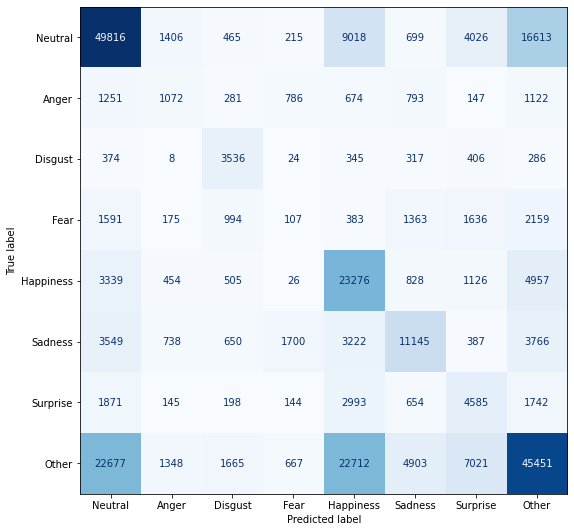

In [20]:
labels=['Neutral','Anger','Disgust','Fear','Happiness','Sadness','Surprise','Other']
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
def plt_conf_matrix(y_true,y_pred,labels):
    print(y_pred.shape,y_true.shape, (y_pred==y_true).mean())

    fig, ax = plt.subplots(figsize=(8, 8))
    plot_confusion_matrix(IC, y_pred,y_true,display_labels=labels,cmap=plt.cm.Blues,ax=ax,colorbar=False,values_format='d') #,normalize='true'
    plt.tight_layout()
    plt.show()
plt_conf_matrix(y_val,y_pred,labels)

enet_b0_8_best_vgaf
aligned
112
Acc: 0.36997808749986594 F1: 0.21352704404593095
(0.21352704404593095, 0.36997808749986594, [0.45700583162587527, 0.07635619242579324, 0.003076194983435873, 0.009468317552804079, 0.34928095010272137, 0.21187660892709106, 0.1647308567096285, 0.4364214000400981])

../expr_enet0_vgaf.h5
Acc: 0.20843684874655494 F1: 0.0910746772554131


224
Acc: 0.47395701146384794 F1: 0.3045351324629094
(0.3045351324629094, 0.47395701146384794, [0.5518323928131282, 0.11104639875752281, 0.028970239662891757, 0.029782898346265387, 0.42825757737346165, 0.5113845517526626, 0.2515561703388993, 0.5234508306584433])

../expr_enet0_vgaf.h5
Acc: 0.42862351608048643 F1: 0.3395506137533413


cropped
Acc: 0.49544436998274705 F1: 0.3844313672414089
(0.3844313672414089, 0.49544436998274705, [0.5975792617828053, 0.18688981868898186, 0.5203826342899192, 0.01771963235902956, 0.4792554615273745, 0.4860550818814191, 0.289585043895661, 0.4979840035060809])
../expr_enet0_vgaf.h5
Acc: 0.500285172458044 F1: 0.3807067519117502
(0.3807067519117502, 0.500285172458044, [0.608643679809698, 0.15128569174948728, 0.5162256615077384, 0.01599360255897641, 0.4778312968664514, 0.4611138100075078, 0.3029224246739377, 0.5116378481202044])


enet_b0_8_va_mtl
aligned
112
Acc: 0.36310406828978836 F1: 0.21416588541497295
(0.21416588541497295, 0.36310406828978836, [0.5104795189391993, 0.1258546760922471, 0.010939722131057872, 0.009548019096038193, 0.33523095946425735, 0.18541315145321896, 0.19094959313671342, 0.3449114430070513])

../expr_enet0_vgaf.h5
Acc: 0.17444566379147022 F1: 0.09599142979803564


224

cropped
Acc: 0.44668344431294826 F1: 0.3355545672821115
(0.3355545672821115, 0.44668344431294826, [0.510145234564414, 0.16641097373883224, 0.3162162162162162, 0.0352055352055352, 0.5013185136754931, 0.4799950349621416, 0.2053190850693402, 0.4698259448249195])
../expr_enet0_vgaf.h5
Acc: 0.4230711647869049 F1: 0.30920724751192785


mobilevit
cropped
224
Acc: 0.46147320091825533 F1: 0.3560574896064487
(0.3560574896064487, 0.46147320091825533, [0.5428998117005389, 0.15102462545204065, 0.44947762979503947, 0.12488323632966876, 0.47030709895410744, 0.40287070773986966, 0.20392039203920392, 0.5030764148411208])

mbf_va
cropped
112
Acc: 0.46184392511371253 F1: 0.32738624577811665
(0.32738624577811665, 0.46184392511371253, [0.5275200664106117, 0.13163163163163163, 0.4120108948382383, 0.02459419576979833, 0.47229383600629454, 0.3058296783625731, 0.21955208437635595, 0.5256575788294297])

aligned
Acc: 0.41698808574829577 F1: 0.2605325777277917
(0.2605325777277917, 0.41698808574829577, [0.5104076268095435, 0.08551319648093843, 0.03246321784527765, 0.04267053701015965, 0.4294620130290349, 0.2965347390252333, 0.2095684295882512, 0.47764086203389466])


enet_b2_best
Acc: 0.4377147705074644 F1: 0.32046977297192947
(0.32046977297192947, 0.4377147705074644, [0.5279750265857089, 0.18667230205691746, 0.32060923369823896, 0.022576492722051686, 0.457802371541502, 0.3702839197046216, 0.23979880986115049, 0.438040027605245])


ddamfnet_8
Acc: 0.43266721800008556 F1: 0.30837374615523644
(0.30837374615523644, 0.43266721800008556, [0.5215368741365138, 0.1129685025514693, 0.3387109850020268, 0.05675889328063242, 0.4707923787344315, 0.29412395223701415, 0.21788596803993387, 0.4542124152598697])

ddamfnet_8_mtl
Acc: 0.4619865113427345 F1: 0.33872014801701744
(0.33872014801701744, 0.4619865113427345, [0.5691907822979275, 0.1422720413882302, 0.2694043321299639, 0.06790817145609246, 0.5095350810593541, 0.4453414505029116, 0.25683655334518146, 0.449272771956478])

Acc: 0.46895184863045924 F1: 0.351079601079747
(0.351079601079747, 0.46895184863045924, [0.5672248538336185, 0.0777629408530359, 0.43501871284949, 0.08656489442592268, 0.4938491272202964, 0.41942100601370563, 0.256280299691494, 0.4725149737504132])


wav2vec2
Acc: 0.410110076568805 F1: 0.29090239611199764
(0.29090239611199764, 0.410110076568805, [0.4758486812936623, 0.047472429043273805, 0.5612936880542514, 0.15109275511960077, 0.13438885152032565, 0.3119477387658142, 0.10830172777075431, 0.5368732973282989])

In [39]:
mlpModel.load_weights('expr_wav2vec2.h5')
y_val_expr_preds_audio=mlpModel.predict(X_val,verbose=0)
#y_val_expr_preds_audio=y_val_preds

y_pred=np.argmax(y_val_expr_preds_audio,axis=1)
print('Acc:',(y_pred==y_val).mean(), 'F1:',f1_score(y_true=y_val,y_pred=y_pred, average="macro"))

Acc: 0.410110076568805 F1: 0.29090239611199764


In [21]:
for w in np.linspace(0,1,11):
    print(w)
    y_ensemble=w*y_val_preds+(1-w)*y_val_expr_preds_audio
    y_pred=np.argmax(y_ensemble,axis=1)
    print('Acc:',(y_pred==y_val).mean(), 'F1:',f1_score(y_true=y_val,y_pred=y_pred, average="macro"))
    

0.0
Acc: 0.410110076568805 F1: 0.29090239611199764
0.1
Acc: 0.43592887798896385 F1: 0.3141889443420316
0.2
Acc: 0.46409678753226014 F1: 0.3439200559542131
0.30000000000000004
Acc: 0.4903932528196427 F1: 0.3723581978456718
0.4
Acc: 0.5081238503985285 F1: 0.3910699591929091
0.5
Acc: 0.5203149729799096 F1: 0.4030154928467773
0.6000000000000001
Acc: 0.5178197139720245 F1: 0.4033380362792486
0.7000000000000001
Acc: 0.5115958250752143 F1: 0.3989305928956265
0.8
Acc: 0.5050725050974577 F1: 0.39334207090252027
0.9
Acc: 0.49983959049235027 F1: 0.3883340065997216
1.0
Acc: 0.49544436998274705 F1: 0.3844313672414089


#### Scores

In [55]:
dirpath=os.path.join(DATA_DIR,'EXPR_Recognition_Challenge/Validation_Set')
num_missed=0
y_scores_all,y_val=[],[]

for filename in os.listdir(dirpath):
    fn, ext = os.path.splitext(os.path.basename(filename))
    if ext.lower()=='.txt':
        with open(os.path.join(dirpath,filename)) as f:
            lines = f.read().splitlines()
            prev_val=None
            for i,line in enumerate(lines):
                if i>0:
                    expression=int(line)
                    #if expression>=0:
                    if expression>=0:
                        imagename=fn+'/'+get_names(i)+'.jpg'
                        if imagename in filename2featuresAll:
                            scores=filename2featuresAll[imagename][1]
                            if False:
                                scores=scores[:-2]
                            y_scores_all.append(scores[AFFECTNET2MTL])
                            y_val.append(expression)
                        else:
                            num_missed+=1
y_scores_all=np.array(y_scores_all)
y_val=np.array(y_val)
print(y_scores_all.shape,y_val.shape,num_missed)

USE_OTHER=True
if USE_OTHER:
    y_scores=np.argmax(y_scores_all,axis=1)
    print(metric_for_Exp(y_val,y_scores,8))
else:
    y_scores=np.argmax(y_scores_all[y_val!=7,:7],axis=1)
    print(metric_for_Exp(y_val[y_val!=7],y_scores,7))

(280532, 8) (280532,) 3698
(0.2289648973411626, 0.28208903084140136, [0.4171540237046687, 0.07984375, 0.034155405405405403, 0.08807582790498107, 0.46493213860781485, 0.43831856324994123, 0.23345359343571406, 0.07578587642077578])


best vgaf
USE_OTHER=True
(280532,) (280532,) 3698
(0.2574340560684253, 0.32562417121754383, [0.47261988187005705, 0.08159349444926674, 0.16895322458679918, 0.08013937282229966, 0.462785267165087, 0.4738317407716553, 0.28230688149375094, 0.037242585388486384])

USE_OTHER=False
(174088,) (174088,) 1883
(0.38315520007157966, 0.5219142043104636, [0.5941131445271728, 0.11673050704408232, 0.2563962686160057, 0.1146315414738341, 0.6221359518916038, 0.574566439059762, 0.40351254788859714])


enet_b0_8_va_mtl_cropped
USE_OTHER=True
(0.25410109876894316, 0.324283860664737, [0.47779652921509314, 0.06600907624798409, 0.14109544418074363, 0.11711266910239954, 0.4439685810172481, 0.5047660714048973, 0.2634610953222214, 0.018599323660957786])

USE_OTHER=False
(0.3806567143774729, 0.5219888791875373, [0.592009268246861, 0.09467766510797036, 0.2184438040345821, 0.15952653171026968, 0.6110634181730246, 0.5997794928335171, 0.3890968205360855])



enet_b2_8_best
USE_OTHER=True
(0.2289648973411626, 0.28208903084140136, [0.4171540237046687, 0.07984375, 0.034155405405405403, 0.08807582790498107, 0.46493213860781485, 0.43831856324994123, 0.23345359343571406, 0.07578587642077578])

USE_OTHER=False
(0.31954104895280455, 0.4427818114976334, [0.5153401958322872, 0.09439149560117302, 0.05797588069056213, 0.12758503785738504, 0.6173376181776966, 0.5075113614059458, 0.31664575310458226])


mobilevit_mtl
USE_OTHER=True
(0.24750764569285288, 0.28692983331669825, [0.3634520018378567, 0.06285218899003035, 0.05460049735106499, 0.10016730923110496, 0.5040490858505564, 0.49996220881895004, 0.2220449054680054, 0.17293296799525437])

USE_OTHER=False
(0.3295391498569603, 0.4335680805110059, [0.46913472299944037, 0.07763645998940116, 0.08706418662239356, 0.14934660858742996, 0.6294146367927087, 0.5681756847928754, 0.3260017492144731])


mbf_va
USE_OTHER=True
(0.24955532401610217, 0.3253176108251465, [0.501757178717933, 0.045738209969191874, 0.0820815680232807, 0.09969902182091799, 0.4926194974590056, 0.47393129948404883, 0.22913333593475632, 0.07148248071968284])

USE_OTHER=False
(0.35399040253219577, 0.5126028215615092, [0.6242666901325824, 0.06287134060710813, 0.1464829586656998, 0.14144649052575395, 0.6331063450645963, 0.5622761420200943, 0.30748285070953557])


ddamfnet_8
USE_OTHER=True
(0.24368332484018906, 0.31544351446537294, [0.4835970920924862, 0.07679580863091136, 0.09747180085569816, 0.11731069138797436, 0.4756866692688539, 0.40775471039776695, 0.2528750278742315, 0.03797479821359013])

USE_OTHER=False
(0.36156862264461503, 0.502113873443316, [0.5944232407027725, 0.12570208941810831, 0.16472753566029058, 0.1628872180451128, 0.643255172413793, 0.4881020717006731, 0.3518830305715552])



ddamfnet_8_mtl
USE_OTHER=True
(0.24541330180175025, 0.3404103631671253, [0.5262782045818408, 0.07189242875697151, 0.05160124485493423, 0.11573461927354747, 0.47414591046785587, 0.46637151586955167, 0.24412813068007455, 0.01315435992922584])

USE_OTHER=False
(0.3659993801626194, 0.5465109599742659, [0.6647896702469529, 0.11337104344686484, 0.06623711340206186, 0.16155474729927802, 0.6478079212454213, 0.5419332426251339, 0.366301922872623])

(280532,) (280532,) 0.32562417121754383


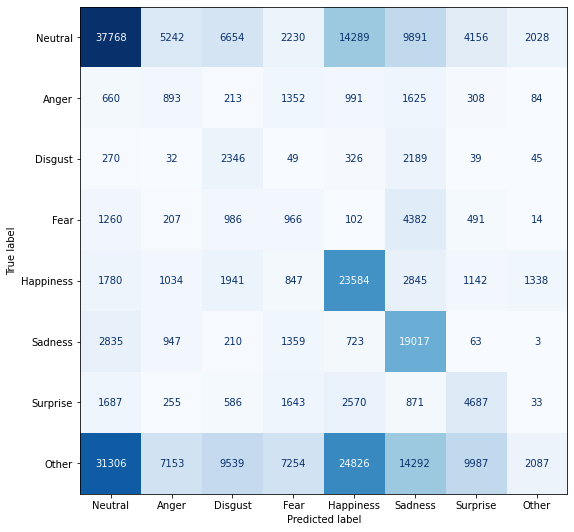

In [16]:
labels=['Neutral','Anger','Disgust','Fear','Happiness','Sadness','Surprise','Other']
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
def plt_conf_matrix(y_true,y_pred,labels):
    print(y_pred.shape,y_true.shape, (y_pred==y_true).mean())

    fig, ax = plt.subplots(figsize=(8, 8))
    plot_confusion_matrix(IC, y_pred,y_true,display_labels=labels,cmap=plt.cm.Blues,ax=ax,colorbar=False,values_format='d') #,normalize='true'
    plt.tight_layout()
    plt.show()
plt_conf_matrix(y_val,y_scores,labels)

### Smooth validation predictions  

In [20]:
data_dir=os.path.join(DATA_DIR,'faces')
dirpath=os.path.join(DATA_DIR,'EXPR_Recognition_Challenge/Validation_Set')
test_videos={}
for filename in tqdm(os.listdir(dirpath)):
    fn, ext = os.path.splitext(os.path.basename(filename))
    if ext.lower()=='.txt':
        X,indices,expressions,scores=[],[],[],[]
        with open(os.path.join(dirpath,filename)) as f:
            lines = f.read().splitlines()
            prev_val=None
            for i,line in enumerate(lines):
                if i>0:
                    imagename=fn+'/'+get_names(i)+'.jpg'
                    if imagename in filename2featuresAll:
                        X.append(filename2featuresAll[imagename][0])
                        indices.append(i)
                        expressions.append(int(line))
                        scores.append(filename2featuresAll[imagename][1][AFFECTNET2MTL])
        test_videos[fn]=(mlpModel.predict(np.array(X),verbose=0),indices,np.array(expressions),np.array(scores))
print(len(test_videos))

100%|██████████| 70/70 [00:38<00:00,  1.81it/s]

70


In [22]:
hyperparams=[(isMean,delta) for delta in [0,2,7]  for isMean in [1,0] if not (isMean==0 and delta==0)]
total_true=[]
total_preds=[[] for _ in range(len(hyperparams))]
for videoname,(y_pred_expr,indices,expressions,scores) in test_videos.items():
    for i,ind in enumerate(indices):
        if expressions[i]>=0:
            total_true.append(expressions[i])
    cur_ind=0
    preds_proba=[]
    for i in range(indices[-1]):
        if indices[cur_ind]-1==i:
            preds_proba.append(y_pred_expr[cur_ind])
            cur_ind+=1
        else:
            if cur_ind==0:
                preds_proba.append(y_pred_expr[cur_ind])
            else:
                w=(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                pred=w*y_pred_expr[cur_ind-1]+(1-w)*y_pred_expr[cur_ind]
                preds_proba.append(pred)
    
    preds_proba=np.array(preds_proba)
    for hInd,(isMean,delta) in enumerate(hyperparams):
        preds=[]
        for i in range(len(preds_proba)):
            i1=max(i-delta,0)
            if isMean:
                proba=np.mean(preds_proba[i1:i+delta+1],axis=0)
            else:
                proba=np.median(preds_proba[i1:i+delta+1],axis=0)
            preds.append(np.argmax(proba))
        for i,ind in enumerate(indices):
            if expressions[i]>=0:
                total_preds[hInd].append(preds[ind-1])

total_true=np.array(total_true)
for hInd,(isMean,delta) in enumerate(hyperparams):
    preds=np.array(total_preds[hInd])
    print('mean' if isMean else 'median',delta,'Acc:',(preds==total_true).mean(), 'F1:',f1_score(y_true=total_true,y_pred=preds, average="macro"))

mean 0 Acc: 0.4377147705074644 F1: 0.32046977297192947
mean 2 Acc: 0.4502053241697917 F1: 0.3308365959569308
median 2 Acc: 0.4485655825360387 F1: 0.3292047135773658
mean 7 Acc: 0.46036815764333483 F1: 0.33783569428081117
median 7 Acc: 0.4585787004691087 F1: 0.3357647927368673


In [21]:
#deltas=[0,1,5,7,15]
deltas=[0,5,15,25,50,100,200,500]
total_true=[]
total_preds=[[] for _ in range(len(deltas))]
for videoname,(y_pred_expr,indices,expressions,scores) in test_videos.items():
    for i,ind in enumerate(indices):
        if expressions[i]>=0:
            total_true.append(expressions[i])
    cur_ind=0
    preds_proba=[]
    for i in range(indices[-1]):
        if indices[cur_ind]-1==i:
            preds_proba.append(y_pred_expr[cur_ind])
            cur_ind+=1
        else:
            if cur_ind==0:
                preds_proba.append(y_pred_expr[cur_ind])
            else:
                w=1-(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                pred=w*y_pred_expr[cur_ind-1]+(1-w)*y_pred_expr[cur_ind]
                preds_proba.append(pred)
    
    preds_proba=np.array(preds_proba)
    for hInd,delta in enumerate(deltas):
        preds=[]
        for i in range(len(preds_proba)):
            i1=max(i-delta,0)
            proba=np.mean(preds_proba[i1:i+delta+1],axis=0)
            preds.append(np.argmax(proba))
        for i,ind in enumerate(indices):
            if expressions[i]>=0:
                total_preds[hInd].append(preds[ind-1])

total_true=np.array(total_true)
for hInd,delta in enumerate(deltas):
    preds=np.array(total_preds[hInd])
    print(delta,'Acc:',(preds==total_true).mean(), 'F1:',f1_score(y_true=total_true,y_pred=preds, average="macro"))

0 Acc: 0.49544436998274705 F1: 0.3844313672414089
5 Acc: 0.5147327221136982 F1: 0.4004462320756203
15 Acc: 0.5290448148517816 F1: 0.41233892932451965
25 Acc: 0.5351189882081189 F1: 0.41821548069619524
50 Acc: 0.5424194031340454 F1: 0.4236679637523476
100 Acc: 0.5408010494346456 F1: 0.41968206198832886
200 Acc: 0.539617583733763 F1: 0.4195667528908445
500 Acc: 0.530777237534399 F1: 0.4032242437980253


0 Acc: 0.49544436998274705 F1: 0.3844313672414089
5 Acc: 0.5147255928022472 F1: 0.40041647458913604
15 Acc: 0.5290234269174283 F1: 0.41233375265784433
25 Acc: 0.5352187985684342 F1: 0.41830667436931435
50 Acc: 0.542572683330244 F1: 0.4236698679610459
100 Acc: 0.5408224373689989 F1: 0.4197549134058517
200 Acc: 0.5397387820284317 F1: 0.41970605922798776
500 Acc: 0.5307736728786734 F1: 0.4031952312654022

In [38]:
if False:
    with open('expr_val_test_videos.pickle', 'wb') as handle:
        pickle.dump(test_videos, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('expr_val_test_videos.pickle', 'rb') as handle:
        test_videos=pickle.load(handle)
print(len(test_videos))

70


### Audio 

In [54]:
data_dir=os.path.join(DATA_DIR,'faces')
dirpath=os.path.join(DATA_DIR,'EXPR_Recognition_Challenge/Validation_Set')
test_audios={}
for filename in tqdm(os.listdir(dirpath)):
    fn, ext = os.path.splitext(os.path.basename(filename))
    fn_short=fn
    if fn.endswith('_left'):
        fn_short=fn[:-5]
    elif fn.endswith('_right'):
        fn_short=fn[:-6]
    if ext.lower()=='.txt':
        X,indices,expressions,scores=[],[],[],[]
        with open(os.path.join(dirpath,filename)) as f:
            lines = f.read().splitlines()
            prev_val=None
            for i,line in enumerate(lines):
                if i>0:
                    imagename=fn+'/'+get_names(i)+'.jpg'
                    imagename_short=fn_short+'/'+get_names(i)+'.jpg'
                    imagename=fn+'/'+get_names(i)+'.jpg'
                    has_image=imagename_short in filename2audio_features
                    has_frame=os.path.exists(os.path.join(DATA_DIR,'cropped',imagename))
                    if has_image:
                        has_image=has_frame
                    elif has_frame:
                        #print(imagename,imagename in filename2audio_features,imagename in filename2featuresAll)
                        imagename_short=fn_short+'/'+get_names(i-1)+'.jpg'
                        has_image=imagename_short in filename2audio_features
                    if has_image:
                        X.append(filename2audio_features[imagename_short])
                        indices.append(i)
                        expressions.append(int(line))
                        scores.append(filename2featuresAll[imagename][1][AFFECTNET2MTL])
        test_audios[fn]=(mlpModel.predict(np.array(X),verbose=0),indices,np.array(expressions),np.array(scores))
print(len(test_audios))


100%|██████████| 70/70 [00:46<00:00,  1.52it/s]

70


In [39]:
if False:
    with open('expr_val_test_audios.pickle', 'wb') as handle:
        pickle.dump(test_audios, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('expr_val_test_audios.pickle', 'rb') as handle:
        test_audios=pickle.load(handle)
print(len(test_audios))

70


In [55]:
#deltas=[0,1,5,7,15]
deltas=[0,5,15,25,50,100,200,500]
total_true=[]
total_preds=[[] for _ in range(len(deltas))]
for videoname,(y_pred_expr,indices,expressions,scores) in test_audios.items():
    for i,ind in enumerate(indices):
        if expressions[i]>=0:
            total_true.append(expressions[i])
    cur_ind=0
    preds_proba=[]
    for i in range(indices[-1]):
        if indices[cur_ind]-1==i:
            preds_proba.append(y_pred_expr[cur_ind])
            cur_ind+=1
        else:
            if cur_ind==0:
                preds_proba.append(y_pred_expr[cur_ind])
            else:
                w=1-(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                pred=w*y_pred_expr[cur_ind-1]+(1-w)*y_pred_expr[cur_ind]
                preds_proba.append(pred)
    
    preds_proba=np.array(preds_proba)
    for hInd,delta in enumerate(deltas):
        preds=[]
        for i in range(len(preds_proba)):
            i1=max(i-delta,0)
            proba=np.mean(preds_proba[i1:i+delta+1],axis=0)
            preds.append(np.argmax(proba))
        for i,ind in enumerate(indices):
            if expressions[i]>=0:
                total_preds[hInd].append(preds[ind-1])

total_true=np.array(total_true)
for hInd,delta in enumerate(deltas):
    preds=np.array(total_preds[hInd])
    print(delta,'Acc:',(preds==total_true).mean(), 'F1:',f1_score(y_true=total_true,y_pred=preds, average="macro"))

0 Acc: 0.410110076568805 F1: 0.29090239611199764
5 Acc: 0.4806474840659889 F1: 0.33263223831368627
15 Acc: 0.5046732636561961 F1: 0.34164236744431886
25 Acc: 0.513214178774614 F1: 0.3457739134483474
50 Acc: 0.5193703392126389 F1: 0.3521084905477545
100 Acc: 0.5205038997333638 F1: 0.35453723394331516
200 Acc: 0.5206037100936791 F1: 0.3551542666808812
500 Acc: 0.5236229734932201 F1: 0.3595042852144297


In [40]:
#Ensemble
deltas=[0,5,15,25,50,100,200,500]
for weight in np.linspace(0,1,11):
    total_true=[]
    total_preds=[[] for _ in range(len(deltas))]
    for videoname,(y_pred_expr,indices,expressions,_) in test_videos.items():
        y_pred_expr_audio,_,_,_=test_audios[videoname]
        for i,ind in enumerate(indices):
            if expressions[i]>=0:
                total_true.append(expressions[i])
        cur_ind=0
        preds_proba=[]
        y_ensemble=weight*y_pred_expr + (1-weight)*y_pred_expr_audio
        for i in range(indices[-1]):
            if indices[cur_ind]-1==i:
                cur_pred=y_ensemble[cur_ind]
                preds_proba.append(cur_pred)
                cur_ind+=1
            else:
                if cur_ind==0:
                    preds_proba.append(y_ensemble[cur_ind])
                else:
                    w=1-(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                    pred=w*y_ensemble[cur_ind-1]+(1-w)*y_ensemble[cur_ind]
                    preds_proba.append(pred)

        preds_proba=np.array(preds_proba)
        for hInd,delta in enumerate(deltas):
            preds=[]
            for i in range(len(preds_proba)):
                i1=max(i-delta,0)
                proba=np.mean(preds_proba[i1:i+delta+1],axis=0)
                preds.append(np.argmax(proba))
            for i,ind in enumerate(indices):
                if expressions[i]>=0:
                    total_preds[hInd].append(preds[ind-1])

    total_true=np.array(total_true)
    print(weight)
    for hInd,delta in enumerate(deltas):
        preds=np.array(total_preds[hInd])
        print(delta,'Acc:',(preds==total_true).mean(), 'F1:',f1_score(y_true=total_true,y_pred=preds, average="macro"))
    print()

0.0
0 Acc: 0.410110076568805 F1: 0.29090239611199764
5 Acc: 0.4806474840659889 F1: 0.33263223831368627
15 Acc: 0.5046732636561961 F1: 0.34164236744431886
25 Acc: 0.513214178774614 F1: 0.3457739134483474
50 Acc: 0.5193703392126389 F1: 0.3521084905477545
100 Acc: 0.5205038997333638 F1: 0.35453723394331516
200 Acc: 0.5206037100936791 F1: 0.3551542666808812
500 Acc: 0.5236229734932201 F1: 0.3595042852144297

0.1
0 Acc: 0.43592887798896385 F1: 0.3141889443420316
5 Acc: 0.5027733021544779 F1: 0.3563857812809881
15 Acc: 0.522806667332069 F1: 0.36445956300269716
25 Acc: 0.531885845465045 F1: 0.3692206390706086
50 Acc: 0.5371579712831335 F1: 0.374503014447069
100 Acc: 0.5369440919396005 F1: 0.3757623082995216
200 Acc: 0.5277651034463091 F1: 0.36969726350868176
500 Acc: 0.5231132277244663 F1: 0.3658137189900791

0.2
0 Acc: 0.46409678753226014 F1: 0.3439200559542131
5 Acc: 0.5192241883278913 F1: 0.3826124760034294
15 Acc: 0.5344630915546177 F1: 0.3892371889323604
25 Acc: 0.5388476180970442 F1: 0.

### Save test results 

In [41]:
with open(os.path.join(DATA_DIR,'../test_set_examples/CVPR_6th_ABAW_Expr_test_set_example.txt'),'r') as f:
    test_set_sample=f.read().splitlines()
print(len(test_set_sample),test_set_sample[:5])

test_set_videos={}
for s in test_set_sample[1:]:
    videoname,img_name=s[:-2].split('/')
    if videoname not in test_set_videos:
        test_set_videos[videoname]=[]
    test_set_videos[videoname].append(img_name)
    
print(len(test_set_videos))

1022656 ['image_location,Neutral,Anger,Disgust,Fear,Happiness,Sadness,Surprise,Other', '14-30-1920x1080/00001.jpg,0', '14-30-1920x1080/00002.jpg,0', '14-30-1920x1080/00003.jpg,0', '14-30-1920x1080/00004.jpg,0']
228


In [42]:
test_videos={}
test_videos_num_frames={}
for videoname,img_files in tqdm(test_set_videos.items()):
    X,indices,filenames,scores=[],[],[],[]
    num_present=num_missed=0
    for img_name in img_files:
        k=videoname+'/'+img_name
        if k in filename2featuresAll:
            X.append(filename2featuresAll[k][0])
            indices.append(int(img_name[:-4]))
            filenames.append(k)
            scores.append(filename2featuresAll[k][1][AFFECTNET2MTL])
            num_present+=1
        else:
            num_missed+=1
    test_videos[videoname]=(mlpModel.predict(np.array(X),verbose=0),indices,filenames,np.array(scores))
    test_videos_num_frames[videoname]=(num_present,num_missed)
print(len(test_videos))

100%|██████████| 228/228 [01:27<00:00,  2.62it/s]

228


In [82]:
test_audios={}
test_audios_num_frames={}
for videoname,img_files in tqdm(test_set_videos.items()):
    X,indices,filenames,scores=[],[],[],[]
    num_present=num_missed=0
    fn_short=videoname
    if videoname.endswith('_left'):
        fn_short=videoname[:-5]
    elif videoname.endswith('_right'):
        fn_short=videoname[:-6]
    for img_name in img_files:
        k=fn_short+'/'+img_name
        if k in filename2audio_features:
            X.append(filename2audio_features[k])
            indices.append(int(img_name[:-4]))
            filenames.append(k)
            num_present+=1
        else:
            num_missed+=1
    test_audios[videoname]=(mlpModel.predict(np.array(X),verbose=0),indices,filenames,np.array(scores))
    test_audios_num_frames[videoname]=(num_present,num_missed)
print(len(test_audios))

100%|██████████| 228/228 [01:20<00:00,  2.84it/s]

228


In [44]:
if False:
    with open('expr_test_audios.pickle', 'wb') as handle:
        pickle.dump(test_audios, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('expr_test_audios.pickle', 'rb') as handle:
        test_audios=pickle.load(handle)
print(len(test_audios))

228


In [48]:
delta=50 # 0 2 4 7
OUTPUT_DIR=DATA_DIR+'/test_results/EXPR'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
print(OUTPUT_DIR)

/home/HDD6TB/datasets/emotions/ABAW/ABAW_6/6th_ABAW_Annotations/test_results/EXPR


In [37]:
#with open(os.path.join(OUTPUT_DIR,'predictions_1_emb.txt'), 'w') as f:
with open(os.path.join(OUTPUT_DIR,'predictions_1_emb_train_val.txt'), 'w') as f:
    f.write(test_set_sample[0]+'\n')
    for videoname,(y_pred_expr,indices,filenames,scores) in test_videos.items():
        cur_ind=0
        preds_proba=[]
        for i in range(indices[-1]):
            if indices[cur_ind]-1==i:
                preds_proba.append(y_pred_expr[cur_ind])
                cur_ind+=1
            else:
                if cur_ind==0:
                    preds_proba.append(y_pred_expr[cur_ind])
                else:
                    w=1-(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                    pred=w*y_pred_expr[cur_ind-1]+(1-w)*y_pred_expr[cur_ind]
                    preds_proba.append(pred)

        pred=y_pred_expr[cur_ind-1]
        for _ in range(indices[-1],len(test_set_videos[videoname])):
            preds_proba.append(pred)

        preds_proba=np.array(preds_proba)
        for i,img_name in enumerate(test_set_videos[videoname]):
            i1=max(i-delta,0)
            proba=np.mean(preds_proba[i1:i+delta+1],axis=0)
            f.write(videoname+'/'+img_name+','+str(np.argmax(proba))+'\n')

In [65]:
weight=0.7

with open(os.path.join(OUTPUT_DIR,'predictions_2_emb_scores.txt'), 'w') as f:
    f.write(test_set_sample[0]+'\n')
    for videoname,(y_pred_expr,indices,filenames,scores) in test_videos.items():
        y_pred_expr_audio,indices_audio,filenames_audio,_=test_audios[videoname]
        cur_ind=0
        preds_proba=[]
        for i in range(indices[-1]):
            if indices[cur_ind]-1==i:
                preds_proba.append(y_pred_expr[cur_ind])
                cur_ind+=1
            else:
                if cur_ind==0:
                    preds_proba.append(y_pred_expr[cur_ind])
                else:
                    w=1-(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                    pred=w*y_pred_expr[cur_ind-1]+(1-w)*y_pred_expr[cur_ind]
                    preds_proba.append(pred)

        pred=y_pred_expr[cur_ind-1]
        for _ in range(indices[-1],len(test_set_videos[videoname])):
            preds_proba.append(pred)

        preds_proba=np.array(preds_proba)
        preds_proba=weight*preds_proba+(1-weight)*y_pred_expr_audio
        for i,img_name in enumerate(test_set_videos[videoname]):
            i1=max(i-delta,0)
            proba=np.mean(preds_proba[i1:i+delta+1],axis=0)
            f.write(videoname+'/'+img_name+','+str(np.argmax(proba))+'\n')


## Valence-Arousal 

In [12]:
def get_image2audio_VA(dirname):
    dirpath=os.path.join(DATA_DIR,'VA_Estimation_Challenge/',dirname)
    num_missed=0
    X,y=[],[]
    for filename in os.listdir(dirpath):
        fn, ext = os.path.splitext(os.path.basename(filename))
        fn_short=fn
        if fn.endswith('_left'):
            fn_short=fn[:-5]
        elif fn.endswith('_right'):
            fn_short=fn[:-6]
        if ext.lower()=='.txt':
            with open(os.path.join(dirpath,filename)) as f:
                lines = f.read().splitlines()
                for i,line in enumerate(lines):
                    if i>0:
                        splitted_line=line.split(',')
                        valence=float(splitted_line[0])
                        arousal=float(splitted_line[1])
                        if valence>=-1 and arousal>=-1:
                            imagename_short=fn_short+'/'+get_names(i)+'.jpg'
                            imagename=fn+'/'+get_names(i)+'.jpg'
                            has_image=imagename_short in filename2audio_features
                            if dirname=='Validation_Set':
                                has_frame=os.path.exists(os.path.join(DATA_DIR,'cropped',imagename))
                                if has_image:
                                    has_image=has_frame
                                elif has_frame:
                                    imagename_short=fn_short+'/'+get_names(i-1)+'.jpg'
                                    has_image=imagename_short in filename2audio_features
                            if has_image:
                                X.append(filename2audio_features[imagename_short])
                                y.append((valence,arousal))
                            else:
                                num_missed+=1
    X=np.array(X)
    y=np.array(y)
    print(X.shape,y.shape,num_missed)
    return X,y

X_train,y_train=get_image2audio_VA('Train_Set')
X_val,y_val=get_image2audio_VA('Validation_Set')
TRAIN_VAL=False

(1679848, 768) (1679848, 2) 9
(376323, 768) (376323, 2) 5698


In [13]:
def get_image2VA(dirname):
    dirpath=os.path.join(DATA_DIR,'VA_Estimation_Challenge/',dirname)
    num_missed=0
    X,y=[],[]
    for filename in os.listdir(dirpath):
        fn, ext = os.path.splitext(os.path.basename(filename))
        if ext.lower()=='.txt':
            with open(os.path.join(dirpath,filename)) as f:
                lines = f.read().splitlines()
                for i,line in enumerate(lines):
                    if i>0:
                        splitted_line=line.split(',')
                        valence=float(splitted_line[0])
                        arousal=float(splitted_line[1])
                        if valence>=-1 and arousal>=-1:
                            imagename=fn+'/'+get_names(i)+'.jpg'
                            if imagename in filename2featuresAll:
                                X.append(filename2featuresAll[imagename][1])
                                y.append((valence,arousal))
                            else:
                                num_missed+=1
    X=np.array(X)
    y=np.array(y)
    print(X.shape,y.shape,num_missed)
    return X,y

X_train,y_train=get_image2VA('Train_Set')
X_val,y_val=get_image2VA('Validation_Set')
TRAIN_VAL=False

(1653930, 10) (1653930, 2) 25927
(376332, 10) (376332, 2) 5689


In [14]:
if True:
    TRAIN_VAL=True
    X_train=np.concatenate((X_train,X_val))
    y_train=np.concatenate((y_train,y_val))
    print(X_train.shape,y_train.shape)

(2030262, 10) (2030262, 2)


In [15]:
def print_ccc_for_val_preds(y_val_preds):
    gt_V=y_val[:,0]
    gt_A=y_val[:,1]
    pred_V=y_val_preds[:,0]
    pred_A=y_val_preds[:,1]
    print(metric_for_VA(gt_V,gt_A,pred_V,pred_A))
    print(CCC_numpy(gt_V,pred_V),CCC_numpy(gt_A,pred_A))

def print_ccc():
    y_val_preds=mlpModel.predict(X_val,verbose=0)
    print_ccc_for_val_preds(y_val_preds)

In [16]:
batch_size=1024 #512 #128
mlpModel=Sequential()
if True:
    mlpModel.add(Dense(2, input_shape=X_train.shape[1:],activation='tanh',use_bias=True,kernel_regularizer=tf.keras.regularizers.l2(1.0/batch_size)))
else:
    mlpModel.add(Dense(128, input_shape=X_train.shape[1:],activation='relu')) #256
    mlpModel.add(Dense(2,activation='tanh'))

In [17]:
mlpModel.compile(optimizer=Adam(learning_rate=1e-3), loss=CCC_VA, metrics=['mae','mse'])
#mlpModel.compile(optimizer=Adam(learning_rate=1e-3), loss='mae', metrics=['mse'])
mlpModel.summary()

save_best_model = SaveBestModel('val_loss',False)
mlpModel.fit(X_train,y_train, batch_size=batch_size, epochs=5, verbose=1, callbacks=[save_best_model], validation_data=(X_val,y_val))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 22        
                                                                 
Total params: 22 (88.00 Byte)
Trainable params: 22 (88.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
1983/1983 [==============================] - 15s 6ms/step - loss: 0.5914 - mae: 0.3997 - mse: 0.2895 - val_loss: 0.7670 - val_mae: 0.2594 - val_mse: 0.1173
Epoch 2/5
1983/1983 [==============================] - 12s 6ms/step - loss: 0.4867 - mae: 0.2651 - mse: 0.1185 - val_loss: 0.7681 - val_mae: 0.2616 - val_mse: 0.1185
Epoch 3/5
1983/1983 [==============================] - 12s 6ms/step - loss: 0.4866 - mae: 0.2652 - mse: 0.1185 - val_loss: 0.7680 - val_mae: 0.2600 - val_mse: 0.1175
Epoch 4/5
1983/1983 [==============================]

In [104]:
print_ccc()
print('Best weights:')
mlpModel.set_weights(best_model_weights)
print_ccc()

(0.4696280993897831, 0.536299121199571, 0.5029636102946771)
0.46962936511930925 0.536300555072494
Best weights:
(0.46969332862979535, 0.5351054590698, 0.5023993938497977)
0.4696945778976984 0.5351069095612824


In [105]:
if False:
    #mlpModel.save_weights('va_enet0_mtl.h5') #(0.44533125143390107, 0.5212460625489065, 0.4832886569914038)
    #mlpModel.save_weights('va_enet0_vgaf.h5')#(0.442104359857453, 0.5205547252402459, 0.48132954254884946)
    mlpModel.save_weights('va_mbf_aligned.h5')#(0.44218117345982105, 0.5326388870069596, 0.48741003023339036)
    #mlpModel.save_weights('va_mobilevit.h5')#(0.44525619437472774, 0.5250882923288589, 0.4851722433517933)
    #mlpModel.save_weights('va_ddamfnet_mtl.h5')#(0.4683555233722727, 0.5365255517977998, 0.5024405375850363)
else:
    mlpModel.load_weights('va_ddamfnet_mtl.h5') #'va_enet0_mtl.h5'
    #mlpModel.load_weights('va_mobilevit.h5')
    #mlpModel.load_weights('va_mbf_aligned.h5')
    #mlpModel.load_weights('../va_enet0_vgaf.h5')
print_ccc()

(0.4683555233722727, 0.5365255517977998, 0.5024405375850363)
0.4683567601070062 0.5365269678175976


VA only emotions

enet_b0_8_best_vgaf
logreg: (0.4436768680313978, 0.5195607326809414, 0.48161880035616955)
new: (0.4433857992438458, 0.5198270222465867, 0.48160641074521626)

enet_b0_8_va_mtl
logreg:(0.44436749382135277, 0.5207544767285259, 0.48256098527493935)
new: (0.44533125143390107, 0.5212460625489065, 0.4832886569914038)


mobilevit
cropped
(0.44525619437472774, 0.5250882923288589, 0.4851722433517933)
0.4452573800456 0.5250896982892981

mbf_va
aligned
Best weights:
(0.4402433504147331, 0.5333364834836402, 0.4867899169491866)
0.4402445269501933 0.5333378888158035

cropped
(0.43943390297626467, 0.531904395626622, 0.48566914930144334)
0.43943507599448606 0.5319058206054035

enet_b2_best
(0.42997560019877556, 0.49753464141700277, 0.46375512080788917)

ddamfnet_8
(0.44043917468810306, 0.5275877349875815, 0.4840134548378423)

ddamfnet_8_mtl
(0.4683555233722727, 0.5365255517977998, 0.5024405375850363)
0.4683567601070062 0.5365269678175976

In [33]:
y_val_preds=mlpModel.predict(X_val)

#### VA predictions 

In [106]:
va_val=X_val[:,-2:]
print_ccc_for_val_preds(va_val)

(0.41247274798276756, 0.23007091554933753, 0.32127183176605256)
0.4124738624553876 0.23007152646343512


In [107]:
va_train=X_train[:,-2:]
print(CCC_numpy(y_train[:,0],va_train[:,0]),CCC_numpy(y_train[:,1],va_train[:,1]))

0.4497610961983525 0.20638218523489857


### Smooth validation predictions

In [108]:
data_dir=os.path.join(DATA_DIR,'faces')
dirpath=os.path.join(DATA_DIR,'VA_Estimation_Challenge/Validation_Set')
test_videos={}
for filename in tqdm(os.listdir(dirpath)):
    fn, ext = os.path.splitext(os.path.basename(filename))
    if ext.lower()=='.txt':
        X,indices,y_true=[],[],[]
        with open(os.path.join(dirpath,filename)) as f:
            lines = f.read().splitlines()
            prev_val=None
            for i,line in enumerate(lines):
                if i>0:
                    imagename=fn+'/'+get_names(i)+'.jpg'
                    if imagename in filename2featuresAll:
                        X.append(filename2featuresAll[imagename][1])
                        indices.append(i)
                        
                        splitted_line=line.split(',')
                        valence=float(splitted_line[0])
                        arousal=float(splitted_line[1])
                        y_true.append((valence,arousal))
                        
        test_videos[fn]=(mlpModel.predict(np.array(X),verbose=0),indices,np.array(y_true))
print(len(test_videos))

100%|██████████| 76/76 [00:24<00:00,  3.04it/s]

76


In [109]:
deltas=[1,10,25,50,100,200]
total_true=[]
total_preds=[[] for _ in range(len(deltas))]
for videoname,(y_pred_va,indices,y_true) in test_videos.items():
    for i,ind in enumerate(indices):
        if y_true[i][0]>=-1 and y_true[i][1]>=-1:
            total_true.append(y_true[i])
    cur_ind=0
    preds=[]
    for i in range(indices[-1]):
        if indices[cur_ind]-1==i:
            preds.append(y_pred_va[cur_ind])
            cur_ind+=1
        else:
            if cur_ind==0:
                preds.append(y_pred_va[cur_ind])
            else:
                w=1-(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                pred=w*y_pred_va[cur_ind-1]+(1-w)*y_pred_va[cur_ind]
                preds.append(pred)
    
    preds=np.array(preds)
    for hInd,delta in enumerate(deltas):
        cur_preds=[]
        for i in range(len(preds)):
            i1=max(i-delta,0)
            pred=np.mean(preds[i1:i+delta+1],axis=0)
            cur_preds.append(pred)
        for i,ind in enumerate(indices):
            if y_true[i][0]>=-1 and y_true[i][1]>=-1:
                total_preds[hInd].append(cur_preds[ind-1])

total_true=np.array(total_true)
gt_V=total_true[:,0]
gt_A=total_true[:,1]

for hInd,delta in enumerate(deltas):
    preds=np.array(total_preds[hInd])
    pred_V=preds[:,0]
    pred_A=preds[:,1]
    print(delta,metric_for_VA(gt_V,gt_A,pred_V,pred_A))

1 (0.47388161776505733, 0.5454483472514844, 0.5096649825082709)
10 (0.4957487055418829, 0.5833074673675026, 0.5395280864546927)
25 (0.5125732030705081, 0.6107215863623221, 0.5616473947164151)
50 (0.5191404219351573, 0.6160994373767202, 0.5676199296559388)
100 (0.5107432980494155, 0.5916885351550036, 0.5512159166022096)
200 (0.4877753631081433, 0.5450888931780282, 0.5164321281430857)


vgaf:
1 (0.44875087823993354, 0.5283116909318734, 0.48853128458590345)
10 (0.4684252179690231, 0.5658810666512365, 0.5171531423101298)
25 (0.4838215785829268, 0.5921912567094488, 0.5380064176461878)
50 (0.48999702278941953, 0.5955375478706236, 0.5427672853300216)
100 (0.4824520565285041, 0.5694326567832584, 0.5259423566558812)
200 (0.46156615573225407, 0.5209989880709679, 0.49128257190161095)

mtl:
1 (0.4497322853156013, 0.5302893781650251, 0.4900108317403132)
10 (0.46963786100578786, 0.5716260813822904, 0.5206319711940391)
25 (0.4843495213418185, 0.6004171233716765, 0.5423833223567476)
50 (0.48997545654787067, 0.6038755689432846, 0.5469255127455777)
100 (0.48241128098915237, 0.5749223688356685, 0.5286668249124105)
200 (0.46145788788100156, 0.5220036569168273, 0.4917307723989144)

mobilevit:
1 (0.4519141824658053, 0.5364566840126457, 0.4941854332392255)
10 (0.4729821091836075, 0.5787780954208082, 0.5258801023022078)
25 (0.48735650719430057, 0.6068810731377108, 0.5471187901660057)
50 (0.49251574941611365, 0.6123478119869349, 0.5524317807015242)
100 (0.4837213847903914, 0.5877672380013604, 0.535744311395876)
200 (0.4619291289073237, 0.5412889919068609, 0.5016090604070923)

mbf_va
aligned
1 (0.4454935971130078, 0.5436244052809025, 0.4945590011969552)
10 (0.46419939071383803, 0.5849226964959962, 0.5245610436049171)
25 (0.4782627706510026, 0.6130468926132803, 0.5456548316321415)
50 (0.4826473183124306, 0.6172188370430775, 0.549933077677754)
100 (0.47342917698341913, 0.5908499883483496, 0.5321395826658843)
200 (0.4519681051409956, 0.5416571527309345, 0.49681262893596506)

cropped
1 (0.44425051319227377, 0.5412209929235514, 0.4927357530579126)
10 (0.46317117806596475, 0.5803567594599781, 0.5217639687629714)
25 (0.47784630968960773, 0.6066599212195685, 0.5422531154545881)
50 (0.48329123443223443, 0.6097693319702527, 0.5465302832012435)
100 (0.4752441002765603, 0.5832174504275345, 0.5292307753520473)
200 (0.45449967125743845, 0.5365046008005447, 0.4955021360289916)

ddamfnet_8
1 (0.44404224361229355, 0.5328501439537299, 0.4884461937830117)
10 (0.4640465013162864, 0.5676875386176197, 0.515867019966953)
25 (0.47901406923550843, 0.5937242357067752, 0.5363691524711418)
50 (0.4849817862941038, 0.5977626889930204, 0.5413722376435621)
100 (0.47720553753616796, 0.5729072064850123, 0.5250563720105901)
200 (0.4555514321445706, 0.5273521035288176, 0.4914517678366941)

ddamfnet_8_mtl
1 (0.47388161776505733, 0.5454483472514844, 0.5096649825082709)
10 (0.4957487055418829, 0.5833074673675026, 0.5395280864546927)
25 (0.5125732030705081, 0.6107215863623221, 0.5616473947164151)
50 (0.5191404219351573, 0.6160994373767202, 0.5676199296559388)
100 (0.5107432980494155, 0.5916885351550036, 0.5512159166022096)
200 (0.4877753631081433, 0.5450888931780282, 0.5164321281430857)

### Save test results 

In [19]:
with open(os.path.join(DATA_DIR,'../test_set_examples/CVPR_6th_ABAW_VA_test_set_example.txt'),'r') as f:
    test_set_sample=f.read().splitlines()
print(len(test_set_sample),test_set_sample[:5])

test_set_videos={}
for s in test_set_sample[1:]:
    videoname,img_name=s.split(',')[0].split('/')
    if videoname not in test_set_videos:
        test_set_videos[videoname]=[]
    test_set_videos[videoname].append(img_name)
    
print(len(test_set_videos))

927211 ['image_location,valence,arousal', '2-30-640x360/00001.jpg,0.5,-0.5', '2-30-640x360/00002.jpg,0.5,-0.5', '2-30-640x360/00003.jpg,0.5,-0.5', '2-30-640x360/00004.jpg,0.5,-0.5']
162


In [20]:
test_videos={}
test_videos_num_frames={}
for videoname,img_files in tqdm(test_set_videos.items()):
    X,indices,filenames=[],[],[]
    num_present=num_missed=0
    for img_name in img_files:
        k=videoname+'/'+img_name
        if k in filename2featuresAll:
            X.append(filename2featuresAll[k][1])
            indices.append(int(img_name[:-4]))
            filenames.append(k)
            num_present+=1
        else:
            num_missed+=1
    X=np.array(X)
    test_videos[videoname]=(mlpModel.predict(X,verbose=0),indices,filenames)
    test_videos_num_frames[videoname]=(num_present,num_missed)
print(len(test_videos))

100%|██████████| 162/162 [01:04<00:00,  2.53it/s]

162


In [22]:
delta=50 # 0 2 4 7
OUTPUT_DIR=DATA_DIR+'/test_results/VA'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
print(OUTPUT_DIR)

/home/HDD6TB/datasets/emotions/ABAW/ABAW_6/6th_ABAW_Annotations/test_results/VA


In [23]:
def write_va_results(res_filename):
    with open(os.path.join(OUTPUT_DIR,res_filename), 'w') as f:
        f.write(test_set_sample[0]+'\n')
        for videoname,(y_pred_va,indices,filenames) in test_videos.items():
            cur_ind=0
            preds=[]
            for i in range(indices[-1]):
                if indices[cur_ind]-1==i:
                    preds.append(y_pred_va[cur_ind])
                    cur_ind+=1
                else:
                    if cur_ind==0:
                        preds.append(y_pred_va[cur_ind])
                    else:
                        w=1-(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                        pred=w*y_pred_va[cur_ind-1]+(1-w)*y_pred_va[cur_ind]
                        preds.append(pred)

            pred=y_pred_va[cur_ind-1]
            for _ in range(indices[-1],len(test_set_videos[videoname])):
                preds.append(pred)

            preds=np.array(preds)
            for i,img_name in enumerate(test_set_videos[videoname]):
                i1=max(i-delta,0)
                pred=np.mean(preds[i1:i+delta+1],axis=0)
                f.write(videoname+'/'+img_name+','+str(pred[0])+','+str(pred[1])+'\n')

In [24]:
#res_filename='predictions_1_ddamfn_mtl.txt'
#res_filename='predictions_2_mvit.txt'
res_filename='predictions_3_mbf_aligned.txt'
#res_filename='predictions_4_ddamfn.txt'
#res_filename='predictions_5_mt_mlp_train_val.txt'
print(delta)
write_va_results(res_filename)

50


## AU (Action Units)

In [12]:
def get_image2AU(dirname):
    dirpath=os.path.join(DATA_DIR,'AU_Detection_Challenge/',dirname)
    num_missed=0
    X,y=[],[]
    for filename in os.listdir(dirpath):
        fn, ext = os.path.splitext(os.path.basename(filename))
        fn_short=fn
        if fn.endswith('_left'):
            fn_short=fn[:-5]
        elif fn.endswith('_right'):
            fn_short=fn[:-6]
        if ext.lower()=='.txt':
            with open(os.path.join(dirpath,filename)) as f:
                lines = f.read().splitlines()
                for i,line in enumerate(lines):
                    if i>0:
                        splitted_line=line.split(',')
                        aus=list(map(int,splitted_line))
                        if min(aus)>=0:
                            imagename_short=fn_short+'/'+get_names(i)+'.jpg'
                            imagename=fn+'/'+get_names(i)+'.jpg'
                            has_image=imagename_short in filename2audio_features
                            if dirname=='Validation_Set':
                                has_frame=os.path.exists(os.path.join(DATA_DIR,'cropped',imagename))
                                if has_image:
                                    has_image=has_frame
                                elif has_frame:
                                    imagename_short=fn_short+'/'+get_names(i-1)+'.jpg'
                                    has_image=imagename_short in filename2audio_features
                            if has_image:
                                X.append(filename2audio_features[imagename_short])
                                y.append(aus)
                            else:
                                num_missed+=1
    X=np.array(X)
    y=np.array(y)
    print(X.shape,y.shape,num_missed)
    return X,y

X_train,y_train=get_image2AU('Train_Set')
X_val,y_val=get_image2AU('Validation_Set')
TRAIN_VAL=False

(1359519, 768) (1359519, 12) 4
(445836, 768) (445836, 12) 9


In [25]:
gc.collect()

1637

In [13]:
def get_image2AU(dirname):
    dirpath=os.path.join(DATA_DIR,'AU_Detection_Challenge/',dirname)
    num_missed=0
    X,y=[],[]
    for filename in os.listdir(dirpath):
        fn, ext = os.path.splitext(os.path.basename(filename))
        if ext.lower()=='.txt':
            with open(os.path.join(dirpath,filename)) as f:
                lines = f.read().splitlines()
                for i,line in enumerate(lines):
                    if i>0:
                        splitted_line=line.split(',')
                        aus=list(map(int,splitted_line))
                        if min(aus)>=0:
                            imagename=fn+'/'+get_names(i)+'.jpg'
                            if imagename in filename2featuresAll:
                                X.append(filename2featuresAll[imagename][0])
                                #X.append(filename2featuresAll[imagename][1])
                                y.append(aus)
                            else:
                                num_missed+=1
    X=np.array(X)
    y=np.array(y)
    print(X.shape,y.shape,num_missed)
    return X,y

#X_train,y_train=get_image2AU('Train_Set')
X_val,y_val=get_image2AU('Validation_Set')
TRAIN_VAL=False

(445836, 1280) (445836, 12) 9


In [31]:
if False:
    TRAIN_VAL=True
    X_train=np.concatenate((X_train,X_val))
    y_train=np.concatenate((y_train,y_val))
    print(X_train.shape,y_train.shape)

In [14]:
def print_au():
    y_val_preds=mlpModel.predict(X_val,verbose=0)
    new_pred = ((y_val_preds >= 0.5) * 1)
    print(np.mean([f1_score(y_true=y_val[:,i],y_pred=new_pred[:,i]) for i in range(y_val_preds.shape[1])]))
    print(f1_score_max(y_val,y_val_preds,thresh=np.arange(0.1,1,0.1)))


In [15]:
num_labels=12 #y_train.shape[1]
print(num_labels)

12


In [15]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = np.empty([num_labels, 2])
for i in range(num_labels):
    neg, pos = np.bincount(y_train[:, i])
    total = neg + pos
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)

    class_weights[i][0]=weight_for_0
    class_weights[i][1]=weight_for_1
    #class_weights[i] = compute_class_weight('balanced', [0,1], y_train[:, i])
print(class_weights)

12
[[ 0.56699251  4.23176065]
 [ 0.52619425 10.04407954]
 [ 0.59098984  3.24755959]
 [ 0.68128675  1.87903072]
 [ 0.82920106  1.25941432]
 [ 0.76269582  1.45167103]
 [ 0.66217018  2.04159042]
 [ 0.51446164 17.78710963]
 [ 0.51622814 15.90534362]
 [ 0.5131443  19.51965355]
 [ 1.33894495  0.79799333]
 [ 0.540114    6.73223767]]


In [16]:
if False:
    loss='binary_crossentropy'
    #loss='hinge'
else:
    import tensorflow.keras.backend as K
    def get_weighted_loss(weights):
        def weighted_loss(y_true, y_pred):
            y_true=tf.cast(y_true, tf.float32)
            ce=K.binary_crossentropy(y_true, y_pred)
            return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*ce, axis=-1)
        return weighted_loss
    loss=get_weighted_loss(class_weights)

In [17]:
metrics=[tf.keras.metrics.AUC(multi_label=True,name='auc'), tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Recall(),tf.keras.metrics.Precision()] # 

In [16]:
batch_size=512 #256 #128
mlpModel=Sequential()
if False:
    mlpModel.add(Dense(y_train.shape[1], input_shape=X_train.shape[1:],activation='sigmoid',use_bias=True,kernel_regularizer=tf.keras.regularizers.l2(1.0/batch_size)))
else:
    mlpModel.add(Dense(128, input_shape=X_val.shape[1:],activation='relu')) #256
    mlpModel.add(Dense(y_val.shape[1],activation='sigmoid'))

In [19]:
mlpModel.compile(optimizer=Adam(learning_rate=1e-3), loss=loss, metrics=metrics)
mlpModel.summary()

save_best_model = SaveBestModel('val_loss',False)
mlpModel.fit(X_train,y_train, batch_size=batch_size, epochs=1 if TRAIN_VAL else 5, verbose=1, callbacks=[save_best_model], validation_data=(X_val,y_val))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 12)                1548      
                                                                 
Total params: 165516 (646.55 KB)
Trainable params: 165516 (646.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
2650/2650 [==============================] - 27s 9ms/step - loss: 0.3159 - auc: 0.9372 - binary_accuracy: 0.8615 - recall: 0.8396 - precision: 0.6070 - val_loss: 0.7022 - val_auc: 0.8198 - val_binary_accuracy: 0.8261 - val_recall: 0.7448 - val_precision: 0.5593
Epoch 2/5
2650/2650 [==============================] - 22s 8ms/step - loss: 0.2556 - auc: 0.9573 - binary_accuracy: 0.8879 - recall: 0.8671 

In [21]:
print_au()
print('Best weights:')
mlpModel.set_weights(best_model_weights)
print_au()

0.491911464367663
(0.5078419186907625, 0.625, array([0.52540132, 0.43592915, 0.5570637 , 0.59322889, 0.73249075,
       0.73485564, 0.69902627, 0.29454367, 0.18605841, 0.17785543,
       0.83247551, 0.32517427]), array([0.8, 0.8, 0.7, 0.5, 0.4, 0.5, 0.6, 0.8, 0.8, 0.9, 0.2, 0.5]), array([0.87440225, 0.90385254, 0.86444343, 0.79203339, 0.76590271,
       0.79922438, 0.85330032, 0.95171543, 0.95005563, 0.95778044,
       0.76229376, 0.81739249]))
Best weights:
0.49971426758356574
(0.5233585232566621, 0.6583333333333333, array([0.54733899, 0.44180561, 0.56990565, 0.61997328, 0.73956417,
       0.74692377, 0.72684634, 0.33222808, 0.17383676, 0.20608964,
       0.83688068, 0.33890931]), array([0.7, 0.8, 0.7, 0.6, 0.5, 0.6, 0.7, 0.8, 0.7, 0.9, 0.3, 0.6]), array([0.86638136, 0.90711158, 0.86534735, 0.80346585, 0.77356472,
       0.81736558, 0.86728304, 0.94037269, 0.9450807 , 0.96134229,
       0.77520658, 0.83503575]))


In [22]:
if True:
    mlpModel.save_weights('au_enet0_vgaf.h5') #0.49971426758356574   with thresholds 0.5233585232566621
    #mlpModel.save_weights('au_enet0_mtl.h5') #0.5051735938712013
else:
    #mlpModel.load_weights('au_enet0_mtl.h5') #0.5051735938712013
    mlpModel.load_weights('../au_enet0_vgaf.h5') #0.507568027779308
    print_au()

In [17]:
#mlpModel.load_weights('au_enet0_mtl.h5') 
mlpModel.load_weights('../au_enet0_vgaf.h5')
#mlpModel.load_weights('au_enet0_vgaf.h5')
y_val_preds=mlpModel.predict(X_val,verbose=0)

thresholds=0.5
#thresholds=np.array([0.8, 0.7, 0.7, 0.6, 0.4, 0.5, 0.7, 0.8, 0.7, 0.8, 0.3, 0.6]) #mtl 0.5231335444336457
thresholds=np.array([0.8, 0.8, 0.7, 0.5, 0.5, 0.5, 0.6, 0.8, 0.8, 0.8, 0.3, 0.7]) #vgaf 0.5367145284583944
#thresholds=np.array([0.7, 0.8, 0.7, 0.6, 0.5, 0.6, 0.7, 0.8, 0.7, 0.9, 0.3, 0.6]) #new vgaf 0.5233

new_pred = ((y_val_preds >= thresholds) * 1)
print(np.mean([f1_score(y_true=y_val[:,i],y_pred=new_pred[:,i]) for i in range(y_val_preds.shape[1])]))

0.5367145284583944


enet_b0_8_best_vgaf
features
dense: 0.507568027779308
(0.5367145284583944, 0.65, array([0.56438654, 0.47163507, 0.57207889, 0.61677155, 0.74818918,
       0.74534595, 0.71942028, 0.35743029, 0.19360184, 0.24140214,
       0.83680711, 0.37350551]), array([0.8, 0.8, 0.7, 0.5, 0.5, 0.5, 0.6, 0.8, 0.8, 0.8, 0.3, 0.7]), array([0.8884859 , 0.90530374, 0.8692748 , 0.79757579, 0.78782557,
       0.80682583, 0.8569631 , 0.94949937, 0.94323473, 0.95116814,
       0.77594452, 0.85026333]))
       
       
 mtl
 0.49428877376095776
(0.524806956530541, 0.7000000000000001, array([0.54610128, 0.42494575, 0.55170266, 0.62691763, 0.74382282,
       0.74725918, 0.7251595 , 0.31431459, 0.21263799, 0.1999356 ,
       0.83512272, 0.36976376]), array([0.8, 0.8, 0.8, 0.6, 0.6, 0.6, 0.6, 0.9, 0.8, 0.9, 0.3, 0.7]), array([0.87291964, 0.89063243, 0.86118887, 0.81252075, 0.78728725,
       0.81416036, 0.86124943, 0.95587391, 0.95360626, 0.94984479,
       0.76649485, 0.83221633]))
  
mobilevit


mbf va
aligned
0.49395180549777845
(0.5138956655767873, 0.6166666666666667, array([0.55458993, 0.46030387, 0.52201501, 0.60131261, 0.73701005,
       0.74490043, 0.72465352, 0.21345907, 0.20569011, 0.18655959,
       0.83514125, 0.38111255]), array([0.7, 0.7, 0.7, 0.5, 0.5, 0.5, 0.6, 0.7, 0.8, 0.8, 0.2, 0.7]), array([0.87584923, 0.89682289, 0.83610672, 0.77777254, 0.77706153,
       0.80617479, 0.86328433, 0.9176844 , 0.93431125, 0.91548408,
       0.76428355, 0.85886126]))
       
cropped
0.48976671672471106
(0.5118960500450163, 0.65, array([0.5574673 , 0.44718576, 0.5341304 , 0.62001219, 0.73774852,
       0.7362523 , 0.72324681, 0.21351073, 0.17458311, 0.19521589,
       0.8317598 , 0.3716398 ]), array([0.8, 0.8, 0.7, 0.5, 0.5, 0.5, 0.6, 0.8, 0.9, 0.8, 0.3, 0.6]), array([0.88496667, 0.90139423, 0.84635382, 0.79159377, 0.77860245,
       0.80225015, 0.85873505, 0.93317498, 0.95459093, 0.92876304,
       0.76869746, 0.83395464]))
       
       
ddamfnet_8
0.4814973773696072
(0.4995985310266646, 0.6249999999999999, array([0.53501881, 0.40728173, 0.5185663 , 0.60379126, 0.72403863,
       0.74413836, 0.71912137, 0.27730055, 0.12892977, 0.15080272,
       0.83702449, 0.34916839]), array([0.7, 0.7, 0.6, 0.5, 0.5, 0.6, 0.7, 0.8, 0.8, 0.7, 0.3, 0.6]), array([0.86551781, 0.8840291 , 0.84430149, 0.78176953, 0.76399842,
       0.81302317, 0.86852565, 0.933009  , 0.92989799, 0.911611  ,
       0.77073632, 0.80953983]))
       
ddamfnet_8_mtl
0.4942434829749742
(0.5186135341795804, 0.6249999999999999, array([0.54665768, 0.42375098, 0.55403914, 0.58823144, 0.74101162,
       0.74306217, 0.71142892, 0.31996645, 0.16365459, 0.22078036,
       0.83975962, 0.37101944]), array([0.8, 0.7, 0.7, 0.5, 0.5, 0.5, 0.6, 0.8, 0.8, 0.8, 0.2, 0.6]), array([0.87629981, 0.88140931, 0.85949766, 0.77443499, 0.78094187,
       0.80757498, 0.85580572, 0.95272028, 0.94197642, 0.94019998,
       0.7711109 , 0.82482796]))
       
       
wav2vec2
0.2840194507261368
(0.3132785640731865, 0.2833333333333334, array([0.25667474, 0.16895004, 0.2680858 , 0.41130376, 0.56997966,
       0.52191738, 0.40528612, 0.0650814 , 0.05036584, 0.06110345,
       0.7870438 , 0.19355077]), array([0.4, 0.2, 0.1, 0.3, 0.1, 0.3, 0.2, 0.5, 0.5, 0.4, 0.1, 0.3]), array([0.27618003, 0.10473807, 0.16910478, 0.41023156, 0.398595  ,
       0.38639545, 0.31180299, 0.7723894 , 0.59011834, 0.45318009,
       0.64886416, 0.16771862]))

### Smooth validation predictions

In [22]:
data_dir=os.path.join(DATA_DIR,'faces')
dirpath=os.path.join(DATA_DIR,'AU_Detection_Challenge/Validation_Set')
test_videos={}
for filename in tqdm(os.listdir(dirpath)):
    fn, ext = os.path.splitext(os.path.basename(filename))
    if ext.lower()=='.txt':
        X,indices,y_true=[],[],[]
        with open(os.path.join(dirpath,filename)) as f:
            lines = f.read().splitlines()
            prev_val=None
            for i,line in enumerate(lines):
                if i>0:
                    imagename=fn+'/'+get_names(i)+'.jpg'
                    if imagename in filename2featuresAll:
                        X.append(filename2featuresAll[imagename][0])
                        indices.append(i)
                        splitted_line=line.split(',')
                        aus=list(map(int,splitted_line))
                        y_true.append(aus)
        test_videos[fn]=(mlpModel.predict(np.array(X),verbose=0),indices,np.array(y_true))
print(len(test_videos))

100%|██████████| 105/105 [00:38<00:00,  2.70it/s]

105


In [23]:
#thresholds=np.array([0.7, 0.7, 0.7, 0.5, 0.5, 0.5, 0.6, 0.7, 0.8, 0.8, 0.2, 0.7])
print(thresholds)

[0.8 0.8 0.7 0.5 0.5 0.5 0.6 0.8 0.8 0.8 0.3 0.7]


In [24]:
deltas=[0,3,5,7,10,15,20,25,50]
total_true=[]
total_preds=[[] for _ in range(len(deltas))]
print(thresholds)
for videoname,(y_pred_aus,indices,y_true) in test_videos.items():
    for i,ind in enumerate(indices):
        if min(y_true[i])>=0:
            total_true.append(y_true[i])
    cur_ind=0
    preds=[]
    for i in range(indices[-1]):
        if indices[cur_ind]-1==i:
            preds.append(y_pred_aus[cur_ind])
            cur_ind+=1
        else:
            if cur_ind==0:
                preds.append(y_pred_aus[cur_ind])
            else:
                w=1-(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                pred=w*y_pred_aus[cur_ind-1]+(1-w)*y_pred_aus[cur_ind]
                preds.append(pred)
    
    preds=np.array(preds)
    for hInd,delta in enumerate(deltas):
        cur_preds=[]
        for i in range(len(preds)):
            i1=max(i-delta,0)
            pred=np.mean(preds[i1:i+delta+1],axis=0)
            aus=(pred>=thresholds)*1
            #aus=(pred>=0.5)*1
            cur_preds.append(aus)
        for i,ind in enumerate(indices):
            if min(y_true[i])>=0:
                total_preds[hInd].append(cur_preds[ind-1])
    

total_true=np.array(total_true)
for hInd,delta in enumerate(deltas):
    preds=np.array(total_preds[hInd])
    f1scores=[f1_score(y_true=total_true[:,i],y_pred=preds[:,i]) for i in range(preds.shape[1])]
    print(delta,np.mean(f1scores),f1scores)

[0.8 0.8 0.7 0.5 0.5 0.5 0.6 0.8 0.8 0.8 0.3 0.7]
0 0.5367145284583944 [0.5643865382761913, 0.47163506664163696, 0.5720788851524985, 0.6167715525660951, 0.7481891822104622, 0.7453459491425192, 0.7194202822032445, 0.35743029196038706, 0.1936018353301045, 0.24140213944736752, 0.8368071098332, 0.37350550873702587]
3 0.5456822065868149 [0.5675945700693865, 0.47961255224573734, 0.5848487169666795, 0.628011471864264, 0.7567708903077084, 0.7562556656908057, 0.7304457640325658, 0.3765327897569832, 0.19647175421209118, 0.24637173650830707, 0.8441359824979983, 0.38113458488925267]
5 0.5454552939073799 [0.5660423118540353, 0.4809454111779693, 0.5857568833985207, 0.6315989382135226, 0.7584234592339255, 0.7565109819851433, 0.7330824865376382, 0.3782388563486549, 0.1837140879196954, 0.24740191734471922, 0.8442784774770199, 0.37946971539771346]
7 0.5446267456097115 [0.561316420201025, 0.480574231235534, 0.5853860710990162, 0.6356760218431688, 0.759301916370733, 0.7552581546398808, 0.7336239402128402,

### Save test results

In [25]:
with open(os.path.join(DATA_DIR,'../test_set_examples/CVPR_6th_ABAW_AU_test_set_example.txt'),'r') as f:
    test_set_sample=f.read().splitlines()
print(len(test_set_sample),test_set_sample[:5])

test_set_videos={}
for s in test_set_sample[1:]:
    videoname,img_name=s.split(',')[0].split('/')
    if videoname not in test_set_videos:
        test_set_videos[videoname]=[]
    test_set_videos[videoname].append(img_name)
    
print(len(test_set_videos))

729737 ['image_location,AU1,AU2,AU4,AU6,AU7,AU10,AU12,AU15,AU23,AU24,AU25,AU26', '2-30-640x360/00001.jpg,1,0,1,1,1,0,0,1,0,0,0,1', '2-30-640x360/00002.jpg,1,0,1,1,1,0,0,1,0,0,0,1', '2-30-640x360/00003.jpg,1,0,1,1,1,0,0,1,0,0,0,1', '2-30-640x360/00004.jpg,1,0,1,1,1,0,0,1,0,0,0,1']
141


In [28]:
test_videos={}
test_videos_num_frames={}
for videoname,img_files in tqdm(test_set_videos.items()):
    X,indices,filenames=[],[],[]
    num_present=num_missed=0
    for img_name in img_files:
        k=videoname+'/'+img_name
        if k in filename2featuresAll:
            X.append(filename2featuresAll[k][0])
            indices.append(int(img_name[:-4]))
            filenames.append(k)
            num_present+=1
        else:
            num_missed+=1
    X=np.array(X)
    test_videos[videoname]=(mlpModel.predict(X,verbose=0),indices,filenames)
    test_videos_num_frames[videoname]=(num_present,num_missed)
print(len(test_videos))


100%|██████████| 141/141 [00:58<00:00,  2.40it/s]

141


In [30]:
delta=5
OUTPUT_DIR=DATA_DIR+'/test_results/AU'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
print(OUTPUT_DIR)

/home/HDD6TB/datasets/emotions/ABAW/ABAW_6/6th_ABAW_Annotations/test_results/AU


In [33]:
def write_au_results(res_filename):
    with open(os.path.join(OUTPUT_DIR,res_filename), 'w') as f:
        f.write(test_set_sample[0]+'\n')
        for videoname,(y_pred_au,indices,filenames) in test_videos.items():
            cur_ind=0
            preds=[]
            for i in range(indices[-1]):
                if indices[cur_ind]-1==i:
                    preds.append(y_pred_au[cur_ind])
                    cur_ind+=1
                else:
                    if cur_ind==0:
                        preds.append(y_pred_au[cur_ind])
                    else:
                        w=1-(i-indices[cur_ind-1]+1)/(indices[cur_ind]-indices[cur_ind-1])
                        pred=w*y_pred_au[cur_ind-1]+(1-w)*y_pred_au[cur_ind]
                        preds.append(pred)

            pred=y_pred_au[cur_ind-1]
            for _ in range(indices[-1],len(test_set_videos[videoname])):
                preds.append(pred)

            preds=np.array(preds)
            for i,img_name in enumerate(test_set_videos[videoname]):
                i1=max(i-delta,0)
                pred=np.mean(preds[i1:i+delta+1],axis=0)
                aus=(pred>=thresholds)*1
                f.write(videoname+'/'+img_name+','+','.join(map(str,aus))+'\n')


In [34]:
res_filename='predictions_1_vgaf.txt'
#res_filename='predictions_2_vgaf_mlp.txt'
#res_filename='predictions_5_vgaf_mlp_train_val.txt'
write_au_results(res_filename)